In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## noncyclic Stocks

### Kweichow Moutai Co.,Ltd.

In [5]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
1  2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2  2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
3  2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
4  2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


In [6]:
df.set_index('Date', inplace=True)

In [10]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1

In [11]:
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
X.shape

(4096, 25, 4)

In [12]:
v = X.reshape(X.shape[0],25, 4)
v[0]

array([[0.68736104, 0.92339235, 0.60920354, 0.6843119 ],
       [0.77827008, 0.90928057, 0.50715169, 0.79246593],
       [0.6762746 , 0.85854748, 0.27249357, 0.66583043],
       [0.76718417, 0.85019549, 0.41713022, 0.81768726],
       [0.91574187, 0.89962995, 0.65348474, 0.93962268],
       [0.84700571, 0.91531642, 0.54412587, 0.78212628],
       [0.72505484, 0.88220752, 0.35010268, 0.67105599],
       [0.72283787, 0.85334911, 0.36674742, 0.61370616],
       [0.76274864, 0.84410988, 0.51679323, 0.66287837],
       [0.72948931, 0.82364242, 0.54774082, 0.59301632],
       [0.86696216, 0.85860939, 0.8768912 , 0.71674908],
       [0.95343673, 0.92108605, 1.        , 0.95762334],
       [0.84035427, 0.93094181, 0.70929736, 0.86526581],
       [1.        , 1.        , 0.95440022, 1.        ],
       [0.73392484, 0.95723642, 0.30459644, 0.75263861],
       [0.65631921, 0.8915358 , 0.11506942, 0.57916486],
       [0.7117509 , 0.85702552, 0.59182721, 0.86123003],
       [0.5565407 , 0.76879279,

In [13]:
y = labels
y = np.array(y)
y.shape

(4096,)

In [14]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [15]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [16]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [17]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [19]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
26/26 [==============================] - 1s 35ms/step - loss: 0.2910 - accuracy: 0.5675 - mse: 0.4313 - weighted_accuracy: 0.3420 - weighted_mse: 0.5213 - val_loss: 0.3009 - val_accuracy: 0.0427 - val_mse: 0.3521 - val_weighted_accuracy: 0.0427 - val_weighted_mse: 0.3521
Epoch 2/200
26/26 [==============================] - 0s 8ms/step - loss: 0.2181 - accuracy: 0.4386 - mse: 0.7218 - weighted_accuracy: 0.3987 - weighted_mse: 0.7417 - val_loss: 0.2930 - val_accuracy: 0.0439 - val_mse: 0.3752 - val_weighted_accuracy: 0.0439 - val_weighted_mse: 0.3752
Epoch 3/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1965 - accuracy: 0.4231 - mse: 0.9226 - weighted_accuracy: 0.4795 - weighted_mse: 0.9319 - val_loss: 0.2851 - val_accuracy: 0.0439 - val_mse: 0.4085 - val_weighted_accuracy: 0.0439 - val_weighted_mse: 0.4085
Epoch 4/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1877 - accuracy: 0.3529 - mse: 1.0572 - weighted_accuracy: 0.5100 - weighte

Epoch 30/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1376 - accuracy: 0.4481 - mse: 1.5266 - weighted_accuracy: 0.7180 - weighted_mse: 1.4708 - val_loss: 0.1913 - val_accuracy: 0.3829 - val_mse: 1.4209 - val_weighted_accuracy: 0.3829 - val_weighted_mse: 1.4209
Epoch 31/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1365 - accuracy: 0.4374 - mse: 1.5416 - weighted_accuracy: 0.7206 - weighted_mse: 1.4784 - val_loss: 0.1840 - val_accuracy: 0.4183 - val_mse: 1.5010 - val_weighted_accuracy: 0.4183 - val_weighted_mse: 1.5010
Epoch 32/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1359 - accuracy: 0.4389 - mse: 1.5590 - weighted_accuracy: 0.7147 - weighted_mse: 1.4933 - val_loss: 0.1879 - val_accuracy: 0.4122 - val_mse: 1.5648 - val_weighted_accuracy: 0.4122 - val_weighted_mse: 1.5648
Epoch 33/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1353 - accuracy: 0.4615 - mse: 1.5725 - weighted_accuracy: 0.7338 - weig

Epoch 59/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1102 - accuracy: 0.6053 - mse: 1.9971 - weighted_accuracy: 0.8166 - weighted_mse: 2.0113 - val_loss: 0.1825 - val_accuracy: 0.5037 - val_mse: 2.0693 - val_weighted_accuracy: 0.5037 - val_weighted_mse: 2.0693
Epoch 60/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1091 - accuracy: 0.5842 - mse: 2.0161 - weighted_accuracy: 0.8154 - weighted_mse: 2.0103 - val_loss: 0.1965 - val_accuracy: 0.4354 - val_mse: 2.2100 - val_weighted_accuracy: 0.4354 - val_weighted_mse: 2.2100
Epoch 61/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1078 - accuracy: 0.6044 - mse: 1.9982 - weighted_accuracy: 0.8227 - weighted_mse: 2.0062 - val_loss: 0.2038 - val_accuracy: 0.4305 - val_mse: 2.2107 - val_weighted_accuracy: 0.4305 - val_weighted_mse: 2.2107
Epoch 62/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1061 - accuracy: 0.6023 - mse: 2.0409 - weighted_accuracy: 0.8220 - weig

Epoch 88/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0865 - accuracy: 0.7161 - mse: 2.6776 - weighted_accuracy: 0.8810 - weighted_mse: 2.7572 - val_loss: 0.2004 - val_accuracy: 0.5329 - val_mse: 2.9297 - val_weighted_accuracy: 0.5329 - val_weighted_mse: 2.9297
Epoch 89/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0840 - accuracy: 0.7137 - mse: 2.7607 - weighted_accuracy: 0.8909 - weighted_mse: 2.8536 - val_loss: 0.1944 - val_accuracy: 0.5829 - val_mse: 3.1822 - val_weighted_accuracy: 0.5829 - val_weighted_mse: 3.1822
Epoch 90/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0850 - accuracy: 0.7146 - mse: 2.7830 - weighted_accuracy: 0.8761 - weighted_mse: 2.8394 - val_loss: 0.1670 - val_accuracy: 0.6207 - val_mse: 3.0233 - val_weighted_accuracy: 0.6207 - val_weighted_mse: 3.0233
Epoch 91/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0830 - accuracy: 0.7378 - mse: 2.7948 - weighted_accuracy: 0.8889 - weig

Epoch 117/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0638 - accuracy: 0.8062 - mse: 3.8444 - weighted_accuracy: 0.9247 - weighted_mse: 3.8730 - val_loss: 0.1793 - val_accuracy: 0.6476 - val_mse: 4.0510 - val_weighted_accuracy: 0.6476 - val_weighted_mse: 4.0510
Epoch 118/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0676 - accuracy: 0.7845 - mse: 3.8735 - weighted_accuracy: 0.9146 - weighted_mse: 3.8400 - val_loss: 0.1699 - val_accuracy: 0.6902 - val_mse: 4.2816 - val_weighted_accuracy: 0.6902 - val_weighted_mse: 4.2816
Epoch 119/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0645 - accuracy: 0.8049 - mse: 3.9859 - weighted_accuracy: 0.9178 - weighted_mse: 4.0086 - val_loss: 0.1787 - val_accuracy: 0.6902 - val_mse: 4.2231 - val_weighted_accuracy: 0.6902 - val_weighted_mse: 4.2231
Epoch 120/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0647 - accuracy: 0.7821 - mse: 4.0131 - weighted_accuracy: 0.9072 - 

Epoch 146/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0524 - accuracy: 0.8379 - mse: 5.2811 - weighted_accuracy: 0.9363 - weighted_mse: 5.0679 - val_loss: 0.2083 - val_accuracy: 0.6817 - val_mse: 5.5821 - val_weighted_accuracy: 0.6817 - val_weighted_mse: 5.5821
Epoch 147/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0522 - accuracy: 0.8571 - mse: 5.3745 - weighted_accuracy: 0.9412 - weighted_mse: 5.1393 - val_loss: 0.2140 - val_accuracy: 0.6939 - val_mse: 5.8458 - val_weighted_accuracy: 0.6939 - val_weighted_mse: 5.8458
Epoch 148/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0520 - accuracy: 0.8407 - mse: 5.4122 - weighted_accuracy: 0.9373 - weighted_mse: 5.2168 - val_loss: 0.2038 - val_accuracy: 0.7012 - val_mse: 5.6059 - val_weighted_accuracy: 0.7012 - val_weighted_mse: 5.6059
Epoch 149/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0501 - accuracy: 0.8422 - mse: 5.4349 - weighted_accuracy: 0.9422 - 

Epoch 175/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0410 - accuracy: 0.8840 - mse: 6.9454 - weighted_accuracy: 0.9510 - weighted_mse: 6.3070 - val_loss: 0.2213 - val_accuracy: 0.7390 - val_mse: 7.6541 - val_weighted_accuracy: 0.7390 - val_weighted_mse: 7.6541
Epoch 176/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0430 - accuracy: 0.8797 - mse: 6.8842 - weighted_accuracy: 0.9516 - weighted_mse: 6.2503 - val_loss: 0.2136 - val_accuracy: 0.7256 - val_mse: 7.2385 - val_weighted_accuracy: 0.7256 - val_weighted_mse: 7.2385
Epoch 177/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0396 - accuracy: 0.8840 - mse: 6.9416 - weighted_accuracy: 0.9575 - weighted_mse: 6.2904 - val_loss: 0.2128 - val_accuracy: 0.7561 - val_mse: 7.1049 - val_weighted_accuracy: 0.7561 - val_weighted_mse: 7.1049
Epoch 178/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0398 - accuracy: 0.8877 - mse: 7.0474 - weighted_accuracy: 0.9546 - 

In [20]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.23490945994853973
Test accuracy: 0.747560977935791


In [21]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-3.861565   -0.97078055  0.60377973]
 [-2.174404   -3.4154553   2.0921118 ]
 [-2.3367784  -0.9006214  -0.13107136]
 ...
 [-1.8567283  -2.0536766   1.0501423 ]
 [-2.7289953  -4.652006    2.1303978 ]
 [-5.27633     1.8681048  -2.2354436 ]]


Counter({2: 669, 0: 82, 1: 69})

In [22]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 747, 1: 36, 0: 37})

In [23]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 820
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 32
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 32
actual holds but predicted buy: 66
actual holds but predicted sell: 76
actual predicted holds: 605
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 13.513513513513514%
Percentage holds correct: 80.99062918340027%
actual buys: 36
actual sells: 37
actual holds: 747


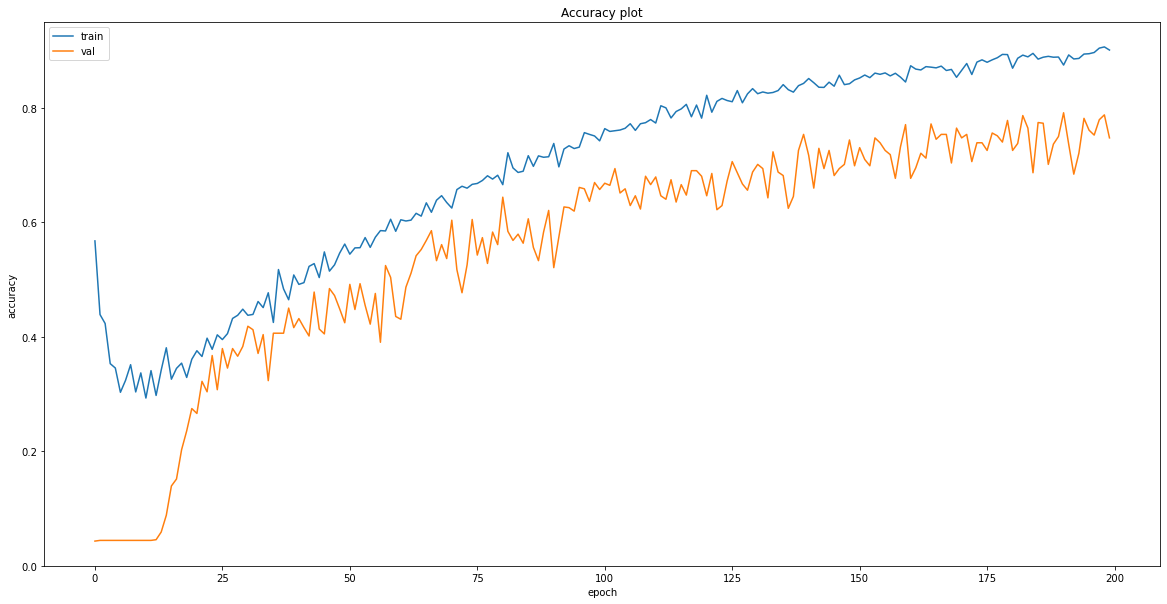

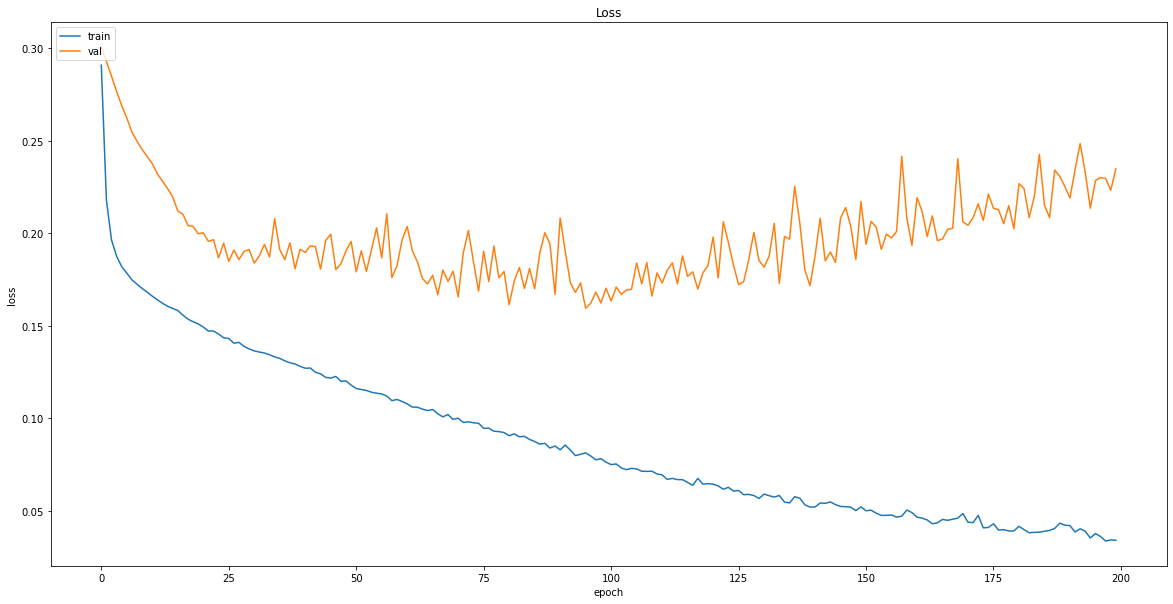

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
# Save model
model.save("models/{}".format('moutai_time_series_lstm_buy_hold_sell_25.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/moutai_time_series_lstm_buy_hold_sell_25.model\assets


### Test Performance

### non-recession

In [26]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-06,610.099976,577.824500,-9.014119,1.233718e+09,2.0
2018-12-07,591.799988,579.974575,-34.788750,1.229942e+09,2.0
2018-12-10,587.000000,581.055409,-41.549296,1.227258e+09,2.0
2018-12-11,577.229980,580.466882,-55.309887,1.224794e+09,2.0
2018-12-12,582.989990,580.855052,-47.197197,1.226426e+09,2.0


In [27]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df2.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1

In [28]:
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(207, 25, 4)

In [29]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [30]:
model = tf.keras.models.load_model("models/moutai_time_series_lstm_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2148 - accuracy: 0.8164 - mean_squared_error: 10.1035 - weighted_accuracy: 0.8164 - weighted_mean_squared_error: 10.1035
Test loss: 0.21475575864315033
Test accuracy: 0.8164251446723938


In [31]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 187, 1: 10, 0: 10})

In [32]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 185, 0: 11, 1: 11})

In [33]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-33-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-33-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-33-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,740.00000,704.389763,-23.444619,43919901.0,2.0,2,2
2019-02-19,730.76001,709.868261,-6.049880,47694490.0,2.0,2,2
2019-02-20,722.00000,713.082376,-17.677836,44744340.0,2.0,2,2
2019-02-21,720.25000,714.454318,-29.824573,40956103.0,2.0,2,2
2019-02-22,726.01001,715.345962,-32.098776,37971063.0,2.0,2,2


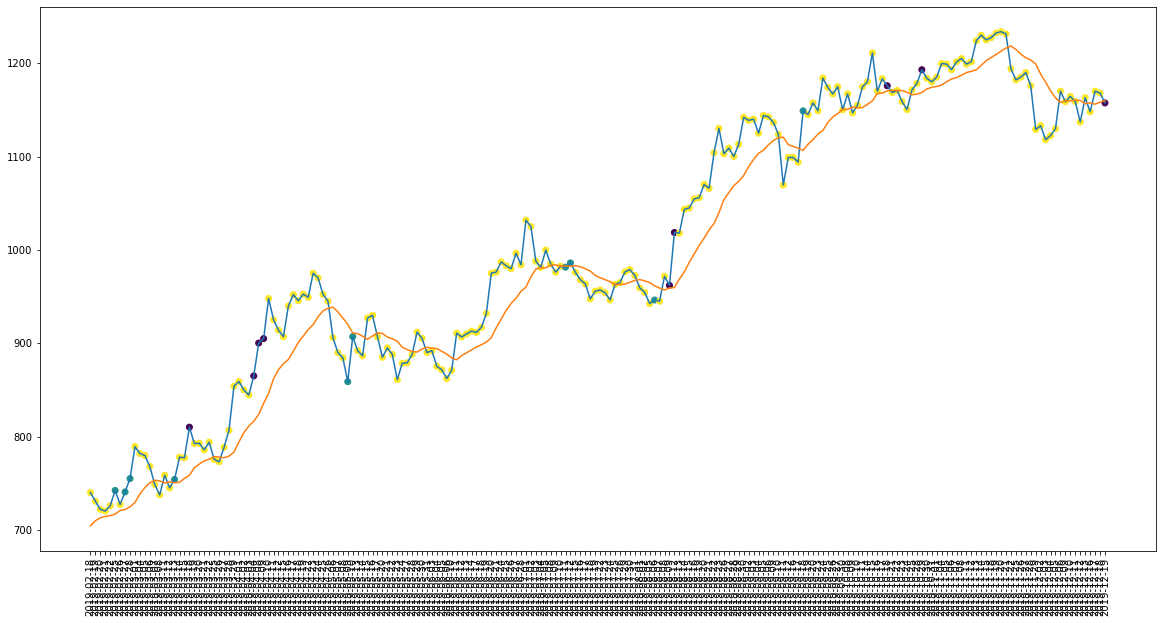

In [34]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [35]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 9
actual holds but predicted sell: 9
actual predicted holds: 167
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 90.27027027027027%
actual buys: 11
actual sells: 11
actual holds: 185


In [36]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[720.25, 722.0, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438, 755.010009765625]
[727.3499755859375, 737.5, 740.7000122070312, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 40.0%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 85.56149732620321%


In [37]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[720.25, 722.0, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438, 755.010009765625]
[727.3499755859375, 737.5, 740.7000122070312, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 40.0%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 85.56149732620321%


In [38]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $742.3300170898438
Shares owned at the moment: 13
Cash capital at the moment: $323.1714797210698


Price increase from previously bought: 8.828737918128748%
Share price: $810.0900268554688
Shares owned at the moment: 0
Cash capital at the moment: $10825.38111038208


Share price: $858.8099975585938
Shares owned at the moment: 12
Cash capital at the moment: $491.3204097595226


Price increase from previously bought: 11.711752872392456%
Share price: $962.030029296875
Shares owned at the moment: 0
Cash capital at the moment: $12003.933770355225


Share price: $1148.9000244140625
Shares owned at the moment: 10
Cash capital at the moment: $483.33877554321225




Capital at the end of test period: $12025.51051901245
profit gained: 20.255105190124503%


In [39]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15358.36826651001
profit gained: 53.5836826651001%


### Recession

In [40]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-09,1170.000000,1159.718126,-55.632382,56851872.0,2.0
2019-12-10,1158.699951,1159.561484,-63.820930,54669460.0,2.0
2019-12-11,1164.400024,1160.305875,-57.992161,56178118.0,2.0
2019-12-12,1158.979980,1160.101891,-60.304908,54721319.0,2.0
2019-12-13,1137.000000,1156.547754,-71.870264,51780403.0,2.0


In [41]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df2.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1

In [42]:
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(208, 25, 4)

In [43]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [44]:
model = tf.keras.models.load_model("models/moutai_time_series_lstm_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2233 - accuracy: 0.7788 - mean_squared_error: 11.1376 - weighted_accuracy: 0.7788 - weighted_mean_squared_error: 11.1376
Test loss: 0.22327248752117157
Test accuracy: 0.7788461446762085


In [45]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 178, 0: 22, 1: 8})

In [46]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [47]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-47-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-47-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-47-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,2,2
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,2,0
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,2,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,2,2
2020-02-25,1074.810059,1092.397016,-40.474836,1203074.0,2.0,2,2


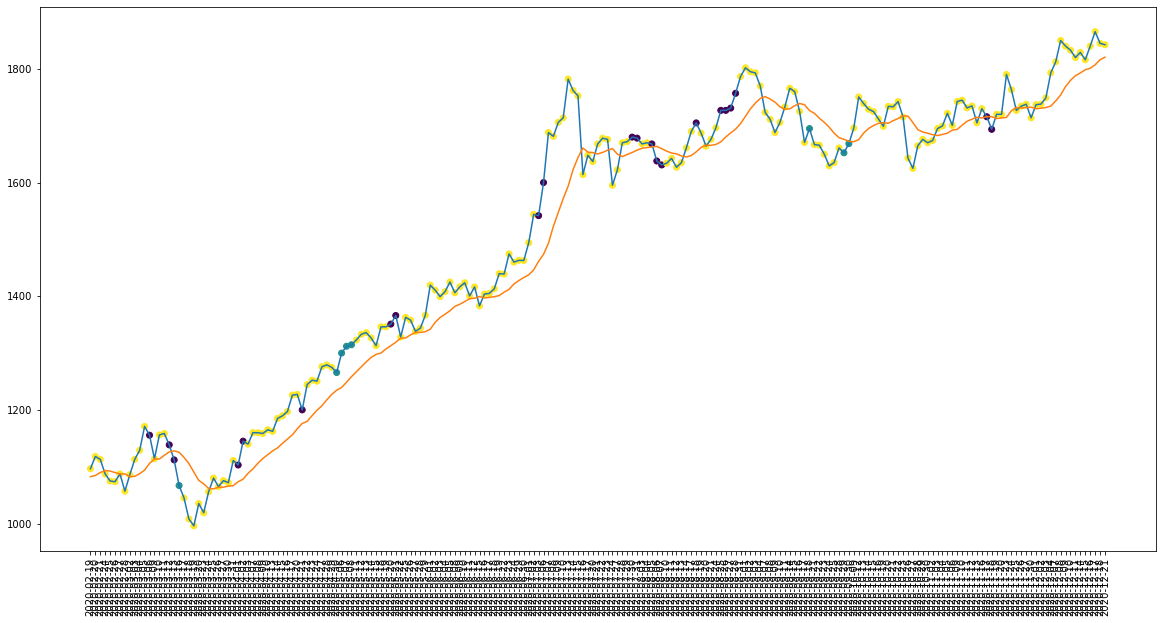

In [48]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [49]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 8
actual holds but predicted sell: 20
actual predicted holds: 161
Percentage buys correct: 0.0%
Percentage sells correct: 10.0%
Percentage holds correct: 85.18518518518519%
actual buys: 9
actual sells: 10
actual holds: 189


In [50]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1086.010009765625, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1156.0, 1171.0]
Percentage buys correct: 25.0%
Percentage sells correct: 45.45454545454545%
Percentage holds correct: 84.7457627118644%


In [51]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1067.0
Shares owned at the moment: 9
Cash capital at the moment: $370.5917499999996


Stop Loss Activated!

Share price: $1007.989990234375
Shares owned at the moment: 0
Cash capital at the moment: $9417.553909851074


Share price: $1265.699951171875
Shares owned at the moment: 7
Cash capital at the moment: $533.2895275878909


Price increase from previously bought: 6.446629603687204%
Share price: $1351.0
Shares owned at the moment: 0
Cash capital at the moment: $9964.28277758789


Share price: $1695.0
Shares owned at the moment: 5
Cash capital at the moment: $1465.9765275878908


Stop Loss Activated!

Share price: $1629.3199462890625
Shares owned at the moment: 0
Cash capital at the moment: $9590.173109771727


Share price: $1652.300048828125
Shares owned at the moment: 5
Cash capital at the moment: $1305.9537399597157




Capital at the end of test period: $10493.119364959715
profit gained: 4.9311936495971525%


In [52]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16641.259749999997
profit gained: 66.41259749999998%


### Midea Group

In [53]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14        OBV_7  labels
0  2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
1  2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2  2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
3  2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
4  2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


In [54]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2013-10-17,11.912000,11.900182,-34.022038,235647532.0,1.0
2013-10-18,11.896000,11.899539,-39.103542,214825024.0,2.0
2013-10-21,12.269333,11.956430,-24.093825,253903732.0,2.0
2013-10-22,12.760000,12.080056,-4.424713,304775737.0,2.0
2013-10-23,12.645333,12.167022,-15.187657,273970459.0,2.0


In [55]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1

In [56]:
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
X.shape

(1243, 25, 4)

In [57]:
y = labels
y = np.array(y)

In [58]:
X[0]

array([[1.07912327e-02, 7.57565463e-04, 6.42210913e-01, 1.12935894e-01],
       [0.00000000e+00, 0.00000000e+00, 5.85071320e-01, 0.00000000e+00],
       [2.51798432e-01, 6.69788361e-02, 7.53849907e-01, 2.11952799e-01],
       [5.82734285e-01, 2.12525250e-01, 9.75021627e-01, 4.87869388e-01],
       [5.05395938e-01, 3.14910884e-01, 8.53996393e-01, 3.20789532e-01],
       [2.66186527e-01, 3.37305780e-01, 5.67962778e-01, 1.43249537e-01],
       [5.19784034e-01, 4.24358297e-01, 6.73381318e-01, 3.91760970e-01],
       [5.55755882e-01, 5.07678271e-01, 7.05898866e-01, 5.99902989e-01],
       [8.74101427e-01, 6.63670705e-01, 1.00000000e+00, 8.12379558e-01],
       [7.76979047e-01, 7.69582326e-01, 8.83748189e-01, 6.16056018e-01],
       [1.00000000e+00, 9.19091582e-01, 9.45611084e-01, 8.62738426e-01],
       [6.81654454e-01, 9.60108497e-01, 6.44675787e-01, 6.57857524e-01],
       [5.66547114e-01, 9.63903322e-01, 5.43316376e-01, 5.11300237e-01],
       [6.07913614e-01, 9.78223201e-01, 5.79742238e

In [59]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [60]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [61]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [98]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [99]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 0 2 2 2 1 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2
 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 0 0 2 2 2 2 2 2 2 2 2 2 0 2 1 2 2 2 2 2 0 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 0 2 2 0 2 2 2 2
 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 0 2 2 0 0 1 2 2 2 2 2 2 0 2 2
 1 1 2 1 2 2 0 2 0 2 2 2 2 2 2 2 0 2 2 2 1 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2
 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 

Epoch 1/200
8/8 [==============================] - 1s 95ms/step - loss: 0.3364 - accuracy: 0.6056 - mse: 0.3351 - weighted_accuracy: 0.3018 - weighted_mse: 0.4498 - val_loss: 0.3028 - val_accuracy: 0.0803 - val_mse: 0.3379 - val_weighted_accuracy: 0.0803 - val_weighted_mse: 0.3379
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2789 - accuracy: 0.5785 - mse: 0.4057 - weighted_accuracy: 0.3873 - weighted_mse: 0.4832 - val_loss: 0.3028 - val_accuracy: 0.0683 - val_mse: 0.3449 - val_weighted_accuracy: 0.0683 - val_weighted_mse: 0.3449
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2455 - accuracy: 0.5493 - mse: 0.4886 - weighted_accuracy: 0.4502 - weighted_mse: 0.5399 - val_loss: 0.3005 - val_accuracy: 0.0602 - val_mse: 0.3503 - val_weighted_accuracy: 0.0602 - val_weighted_mse: 0.3503
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2245 - accuracy: 0.5050 - mse: 0.5757 - weighted_accuracy: 0.4586 - weighted_mse

8/8 [==============================] - 0s 8ms/step - loss: 0.1407 - accuracy: 0.4759 - mse: 1.2823 - weighted_accuracy: 0.7369 - weighted_mse: 1.2593 - val_loss: 0.2211 - val_accuracy: 0.0964 - val_mse: 0.6944 - val_weighted_accuracy: 0.0964 - val_weighted_mse: 0.6944
Epoch 31/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1395 - accuracy: 0.4879 - mse: 1.2928 - weighted_accuracy: 0.7555 - weighted_mse: 1.2626 - val_loss: 0.2184 - val_accuracy: 0.1325 - val_mse: 0.7081 - val_weighted_accuracy: 0.1325 - val_weighted_mse: 0.7081
Epoch 32/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1379 - accuracy: 0.4859 - mse: 1.3020 - weighted_accuracy: 0.7470 - weighted_mse: 1.2697 - val_loss: 0.2152 - val_accuracy: 0.1928 - val_mse: 0.7221 - val_weighted_accuracy: 0.1928 - val_weighted_mse: 0.7221
Epoch 33/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1360 - accuracy: 0.4970 - mse: 1.3062 - weighted_accuracy: 0.7433 - weighted_mse: 1.2800 - va

8/8 [==============================] - 0s 8ms/step - loss: 0.1107 - accuracy: 0.6137 - mse: 1.4964 - weighted_accuracy: 0.8520 - weighted_mse: 1.4811 - val_loss: 0.1560 - val_accuracy: 0.6345 - val_mse: 1.1171 - val_weighted_accuracy: 0.6345 - val_weighted_mse: 1.1171
Epoch 60/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1109 - accuracy: 0.6227 - mse: 1.4961 - weighted_accuracy: 0.8320 - weighted_mse: 1.4872 - val_loss: 0.1567 - val_accuracy: 0.6145 - val_mse: 1.1372 - val_weighted_accuracy: 0.6145 - val_weighted_mse: 1.1372
Epoch 61/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1089 - accuracy: 0.6258 - mse: 1.5015 - weighted_accuracy: 0.8344 - weighted_mse: 1.5043 - val_loss: 0.1547 - val_accuracy: 0.6104 - val_mse: 1.1581 - val_weighted_accuracy: 0.6104 - val_weighted_mse: 1.1581
Epoch 62/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1083 - accuracy: 0.6368 - mse: 1.5098 - weighted_accuracy: 0.8605 - weighted_mse: 1.5084 - va

8/8 [==============================] - 0s 8ms/step - loss: 0.0855 - accuracy: 0.7163 - mse: 1.8007 - weighted_accuracy: 0.8883 - weighted_mse: 1.8647 - val_loss: 0.1531 - val_accuracy: 0.6104 - val_mse: 1.7354 - val_weighted_accuracy: 0.6104 - val_weighted_mse: 1.7354
Epoch 89/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0841 - accuracy: 0.7183 - mse: 1.8360 - weighted_accuracy: 0.8890 - weighted_mse: 1.8709 - val_loss: 0.1502 - val_accuracy: 0.6466 - val_mse: 1.7751 - val_weighted_accuracy: 0.6466 - val_weighted_mse: 1.7751
Epoch 90/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0853 - accuracy: 0.7103 - mse: 1.8532 - weighted_accuracy: 0.8938 - weighted_mse: 1.8657 - val_loss: 0.1531 - val_accuracy: 0.6466 - val_mse: 1.7725 - val_weighted_accuracy: 0.6466 - val_weighted_mse: 1.7725
Epoch 91/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0824 - accuracy: 0.7153 - mse: 1.8613 - weighted_accuracy: 0.8815 - weighted_mse: 1.8974 - va

8/8 [==============================] - 0s 8ms/step - loss: 0.0633 - accuracy: 0.7988 - mse: 2.3979 - weighted_accuracy: 0.9263 - weighted_mse: 2.4231 - val_loss: 0.1645 - val_accuracy: 0.7229 - val_mse: 2.7557 - val_weighted_accuracy: 0.7229 - val_weighted_mse: 2.7557
Epoch 118/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0625 - accuracy: 0.8219 - mse: 2.4156 - weighted_accuracy: 0.9347 - weighted_mse: 2.4171 - val_loss: 0.1699 - val_accuracy: 0.6988 - val_mse: 2.7144 - val_weighted_accuracy: 0.6988 - val_weighted_mse: 2.7144
Epoch 119/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0624 - accuracy: 0.8058 - mse: 2.4282 - weighted_accuracy: 0.9288 - weighted_mse: 2.4025 - val_loss: 0.1801 - val_accuracy: 0.6586 - val_mse: 2.6318 - val_weighted_accuracy: 0.6586 - val_weighted_mse: 2.6318
Epoch 120/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0597 - accuracy: 0.8239 - mse: 2.4405 - weighted_accuracy: 0.9355 - weighted_mse: 2.4183 -

Epoch 146/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0496 - accuracy: 0.8652 - mse: 3.2854 - weighted_accuracy: 0.9506 - weighted_mse: 3.1341 - val_loss: 0.2454 - val_accuracy: 0.6345 - val_mse: 3.5745 - val_weighted_accuracy: 0.6345 - val_weighted_mse: 3.5745
Epoch 147/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0472 - accuracy: 0.8571 - mse: 3.3149 - weighted_accuracy: 0.9476 - weighted_mse: 3.1359 - val_loss: 0.2147 - val_accuracy: 0.6948 - val_mse: 3.6204 - val_weighted_accuracy: 0.6948 - val_weighted_mse: 3.6204
Epoch 148/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0486 - accuracy: 0.8702 - mse: 3.3353 - weighted_accuracy: 0.9524 - weighted_mse: 3.1521 - val_loss: 0.2086 - val_accuracy: 0.7309 - val_mse: 3.6536 - val_weighted_accuracy: 0.7309 - val_weighted_mse: 3.6536
Epoch 149/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0458 - accuracy: 0.8722 - mse: 3.3901 - weighted_accuracy: 0.9532 - weighted

Epoch 175/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0368 - accuracy: 0.8974 - mse: 4.3947 - weighted_accuracy: 0.9624 - weighted_mse: 3.9239 - val_loss: 0.2513 - val_accuracy: 0.7510 - val_mse: 5.2447 - val_weighted_accuracy: 0.7510 - val_weighted_mse: 5.2447
Epoch 176/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0362 - accuracy: 0.8994 - mse: 4.4377 - weighted_accuracy: 0.9631 - weighted_mse: 3.9332 - val_loss: 0.2440 - val_accuracy: 0.7631 - val_mse: 5.1978 - val_weighted_accuracy: 0.7631 - val_weighted_mse: 5.1978
Epoch 177/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0366 - accuracy: 0.8944 - mse: 4.4264 - weighted_accuracy: 0.9613 - weighted_mse: 3.9736 - val_loss: 0.2438 - val_accuracy: 0.7470 - val_mse: 5.0684 - val_weighted_accuracy: 0.7470 - val_weighted_mse: 5.0684
Epoch 178/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0347 - accuracy: 0.9014 - mse: 4.4572 - weighted_accuracy: 0.9639 - weighted

In [100]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.27305838465690613
Test accuracy: 0.7710843086242676


In [101]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-3.05831003e+00  2.82397270e-01 -4.64700967e-01]
 [-4.24144387e-01 -3.49245906e+00  2.42662519e-01]
 [-3.94789457e+00 -3.47891521e+00  3.10491538e+00]
 [-2.28610587e+00 -1.70911622e+00  1.07170236e+00]
 [-3.12457943e+00 -2.71492577e+00  1.87593150e+00]
 [-3.77231121e+00 -2.95288253e+00  2.74022794e+00]
 [-2.17607307e+00 -2.97884226e+00  2.13580823e+00]
 [-3.62976694e+00  3.22962075e-01 -1.02170610e+00]
 [-3.46395135e+00 -1.64499867e+00  1.40233505e+00]
 [-1.13787258e+00 -3.59367275e+00  1.26907587e+00]
 [-1.98427543e-01  5.50754607e-01 -2.76814866e+00]
 [-1.90965295e+00 -2.48472643e+00  1.55022049e+00]
 [-3.60947728e+00 -3.06437969e+00  2.90822387e+00]
 [-3.99283576e+00 -1.50517166e+00  7.93245196e-01]
 [ 1.20449615e+00 -3.70892978e+00 -1.51060259e+00]
 [-1.93458486e+00 -3.83003330e+00  1.53338027e+00]
 [-2.65486836e+00 -2.31626821e+00  2.37546945e+00]
 [-2.79983091e+00 -3.07896686e+00  2.01642370e+00]
 [-3.49710584e+00 -1.16409564e+00  3.49645048e-01]
 [-2.92648673e+00 -5.71461868e+

Counter({1: 19, 2: 215, 0: 15})

In [102]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 226, 1: 12, 0: 11})

In [103]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 249
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 12
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 11
actual holds but predicted buy: 19
actual holds but predicted sell: 15
actual predicted holds: 192
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 84.95575221238938%
actual buys: 12
actual sells: 11
actual holds: 226


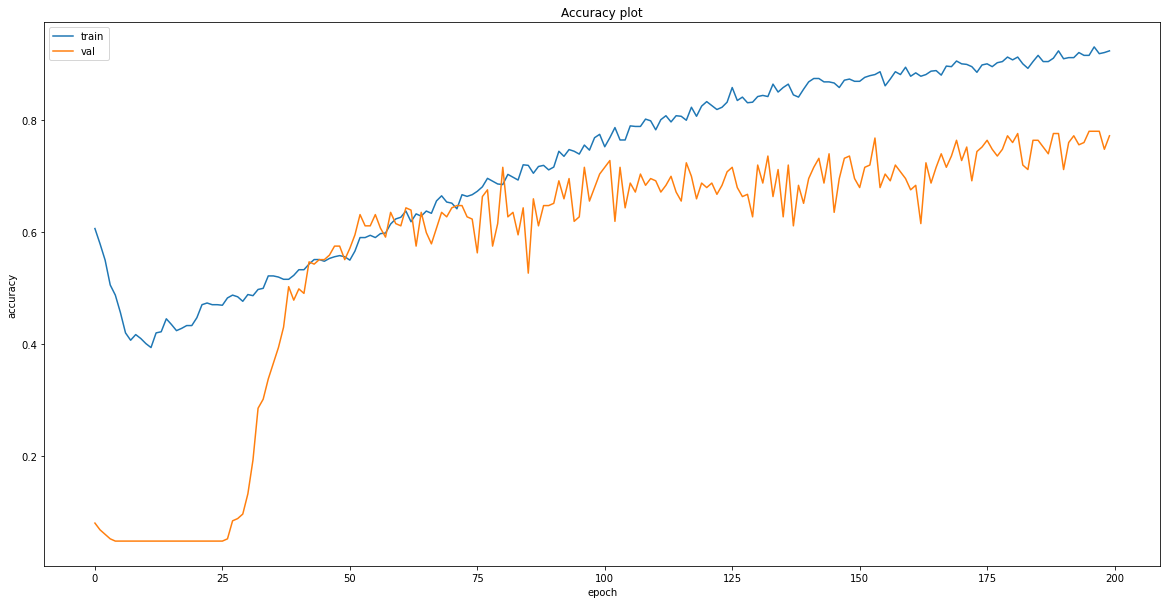

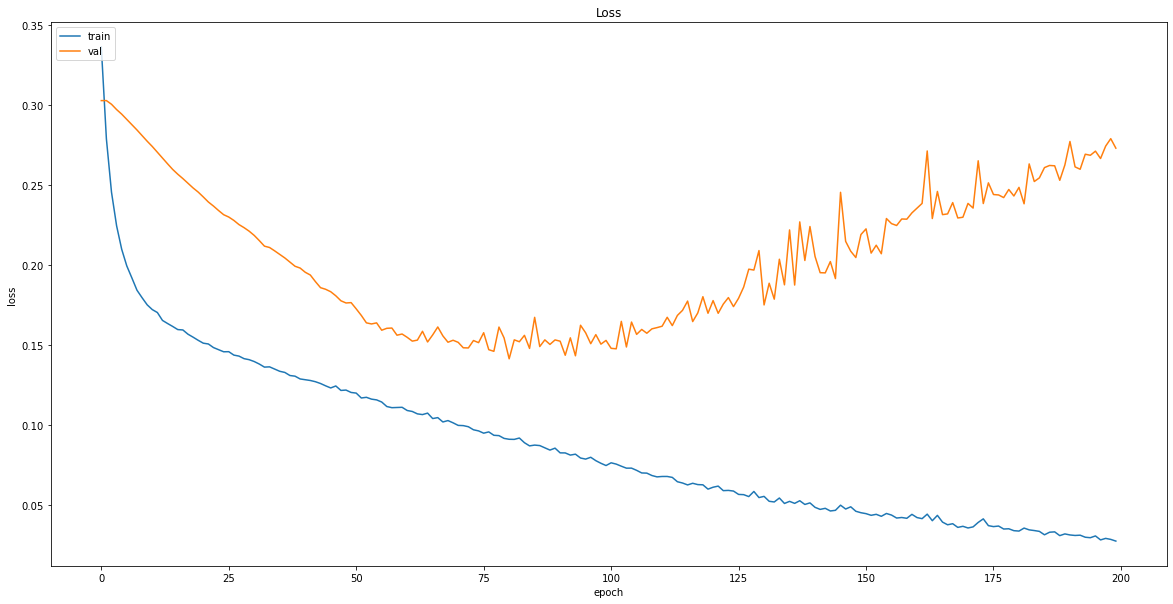

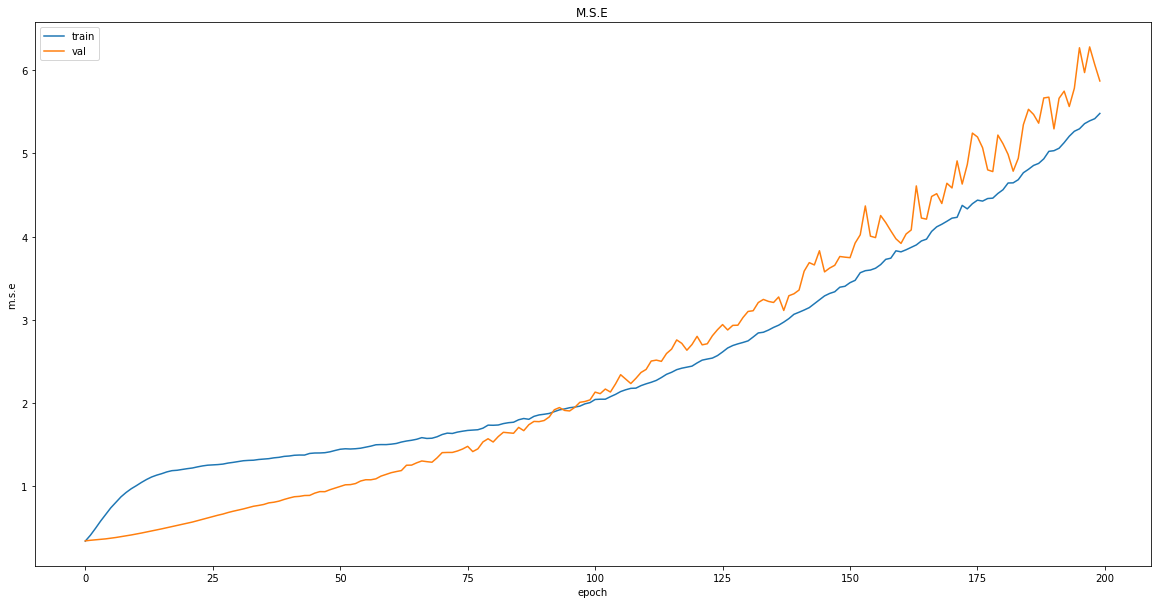

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [105]:
# Save model
model.save("models/{}".format('midea_time_series_lstm_buy_hold_sell_25.model'))

INFO:tensorflow:Assets written to: models/midea_time_series_lstm_buy_hold_sell_25.model\assets


### Test Performance

### non-recession

In [106]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-06,40.000000,40.092585,-59.624405,5.053315e+09,2.0
2018-12-07,38.959999,39.918341,-83.886253,5.032045e+09,2.0
2018-12-10,38.480000,39.697058,-94.264348,5.009379e+09,2.0
2018-12-11,37.060001,39.291357,-91.990799,4.974723e+09,1.0
2018-12-12,37.040001,38.944994,-87.280665,4.947635e+09,2.0


In [107]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df2.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1

In [108]:
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(207, 25, 4)

In [109]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [110]:
model = tf.keras.models.load_model("models/midea_time_series_lstm_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1621 - accuracy: 0.8551 - mean_squared_error: 5.8878 - weighted_accuracy: 0.8551 - weighted_mean_squared_error: 5.8878
Test loss: 0.1620965600013733
Test accuracy: 0.8550724387168884


In [111]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 198, 0: 6, 1: 3})

In [112]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 186, 0: 10, 1: 11})

In [113]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-113-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-113-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-113-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,46.400002,44.456141,-30.862341,419918481.0,2.0,2,2
2019-02-19,46.080002,44.755197,-13.767016,452488699.0,2.0,2,2
2019-02-20,46.080002,44.959013,-18.975880,424412835.0,2.0,2,2
2019-02-21,45.860001,45.131473,-18.975880,424412835.0,2.0,2,2
2019-02-22,45.610001,45.243554,-26.174460,382970560.0,2.0,2,2


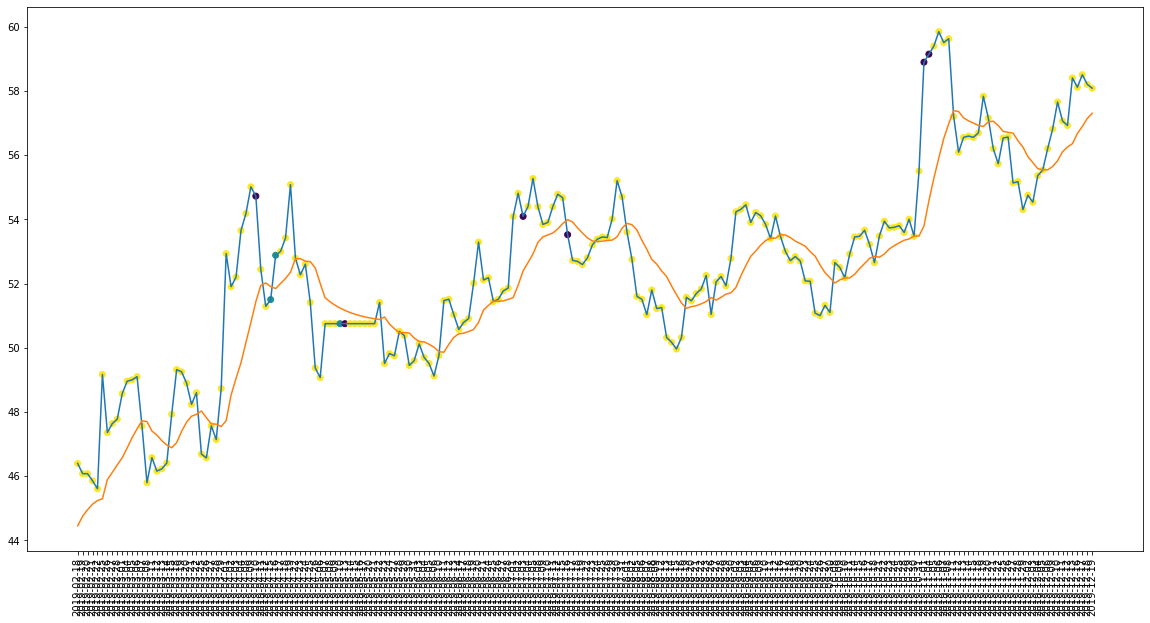

In [114]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

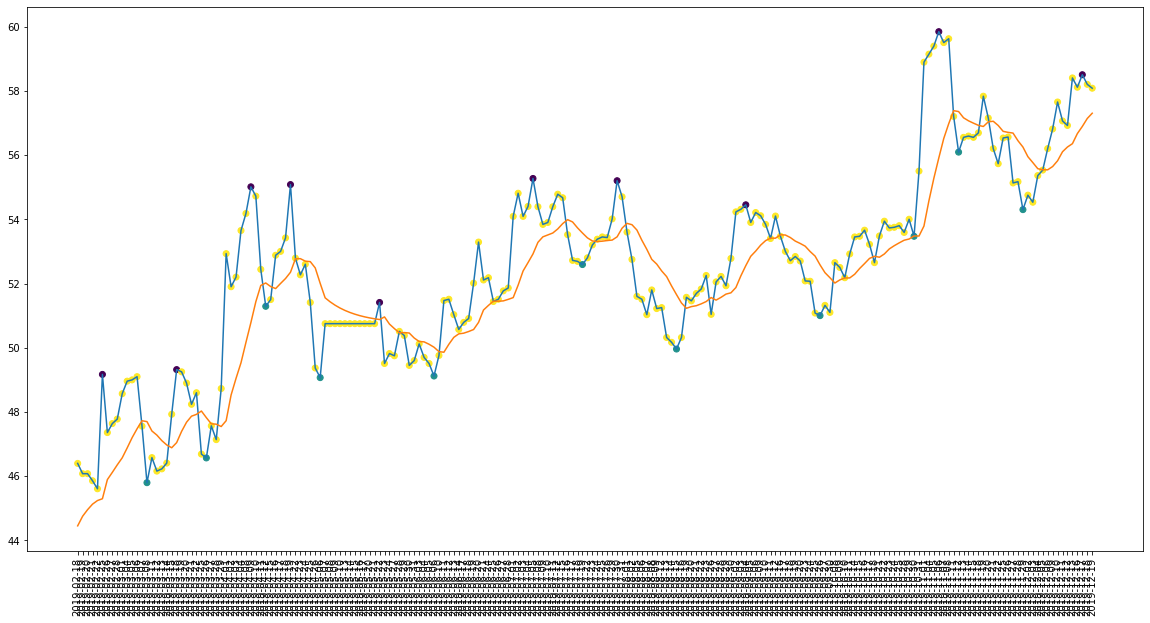

In [115]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [116]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 3
actual holds but predicted sell: 6
actual predicted holds: 177
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 95.16129032258064%
actual buys: 11
actual sells: 10
actual holds: 186


In [117]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[45.61000061035156, 45.86000061035156, 46.08000183105469, 46.08000183105469, 46.4000015258789, 47.36000061035156, 47.63999938964844, 47.77999877929688, 49.16999816894531]
[45.79999923706055, 47.36000061035156, 47.56000137329102, 47.63999938964844, 47.77999877929688, 48.56999969482422, 48.959999084472656, 49.0, 49.099998474121094]
Percentage buys correct: 66.66666666666667%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 79.69543147208122%


In [118]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $51.5
Shares owned at the moment: 193
Cash capital at the moment: $33.16637499999888


Stop Loss Activated!

Share price: $49.36999893188477
Shares owned at the moment: 0
Cash capital at the moment: $9535.373041920662


Share price: $50.75
Shares owned at the moment: 187
Cash capital at the moment: $19.02485442066245


Stop Loss Activated!

Share price: $49.11999893188477
Shares owned at the moment: 0
Cash capital at the moment: $9179.204695232393




Capital at the end of test period: $9179.204695232393
profit gained: -8.207953047676074%


In [119]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12438.033583332062
profit gained: 24.380335833320625%


### recession

In [120]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-09,56.200001,55.641030,-41.801348,1.203534e+09,2.0
2019-12-10,56.810001,55.820872,-27.713568,1.224386e+09,2.0
2019-12-11,57.650002,56.102276,-5.476179,1.245103e+09,2.0
2019-12-12,57.060001,56.249619,-19.523799,1.231138e+09,2.0
2019-12-13,56.919998,56.352754,-22.857208,1.218430e+09,2.0


In [121]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df2.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1

In [122]:
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(208, 25, 4)

In [123]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [124]:
model = tf.keras.models.load_model("models/midea_time_series_lstm_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2026 - accuracy: 0.7212 - mean_squared_error: 5.4812 - weighted_accuracy: 0.7212 - weighted_mean_squared_error: 5.4812
Test loss: 0.2025803178548813
Test accuracy: 0.7211538553237915


In [125]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 161, 1: 19, 0: 28})

In [126]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 8, 1: 7})

In [127]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-127-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-127-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-127-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,53.540001,54.301035,-52.927131,-33290149.0,2.0,2,2
2020-02-20,54.860001,54.183953,-44.755246,-9557295.0,2.0,2,2
2020-02-21,54.279999,54.287960,-8.665511,27483857.0,2.0,2,2
2020-02-24,54.910000,54.286736,-21.343904,-2296012.0,0.0,2,0
2020-02-25,54.430000,54.382622,-12.602723,38486402.0,2.0,2,2


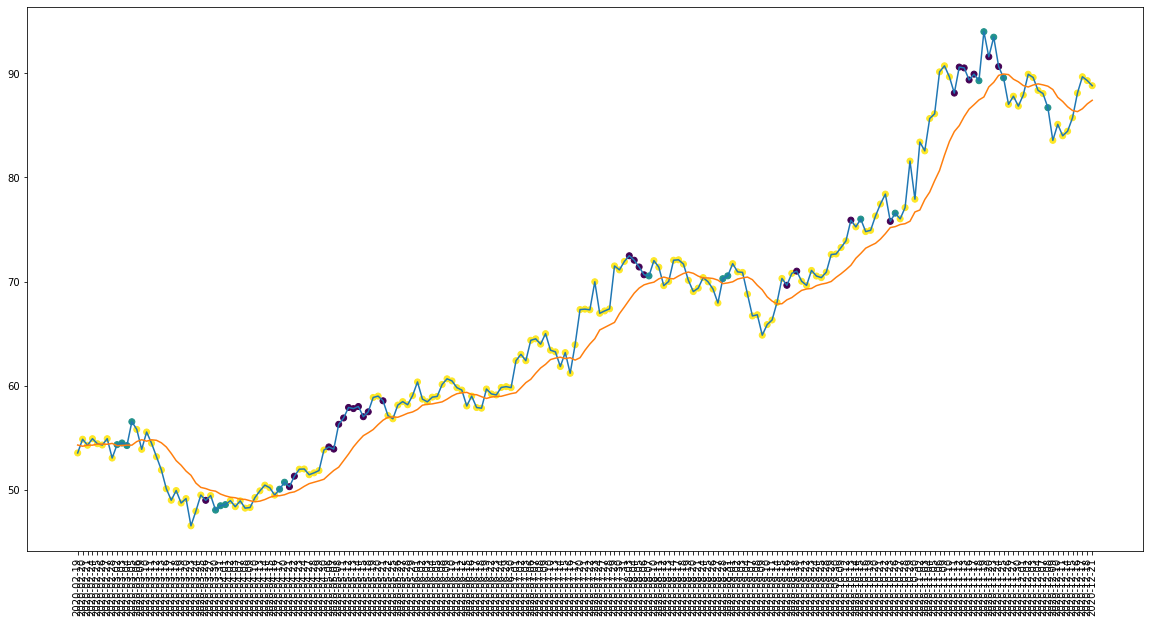

In [128]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

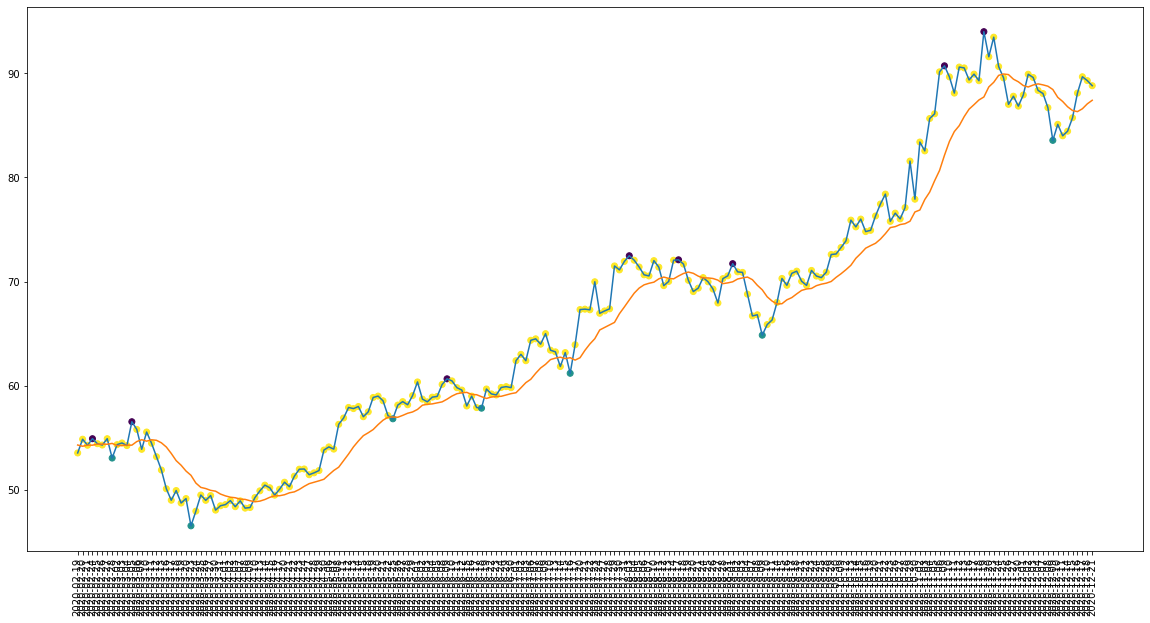

In [129]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [130]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 2
actual predicted sells: 1
actual sells but predicted hold: 5
actual holds but predicted buy: 17
actual holds but predicted sell: 27
actual predicted holds: 149
Percentage buys correct: 0.0%
Percentage sells correct: 12.5%
Percentage holds correct: 77.20207253886011%
actual buys: 7
actual sells: 8
actual holds: 193


In [131]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[53.04999923706055, 53.540000915527344, 54.27999877929688, 54.29999923706055, 54.34000015258789, 54.43000030517578, 54.86000061035156, 54.90999984741211, 54.90999984741211]
[53.04999923706055, 53.88999938964844, 54.25, 54.34000015258789, 54.5, 54.90999984741211, 55.54999923706055, 55.79999923706055, 56.540000915527344]
Percentage buys correct: 47.36842105263158%
Percentage sells correct: 50.0%
Percentage holds correct: 83.75%


In [132]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $54.34000015258789
Shares owned at the moment: 183
Cash capital at the moment: $28.43336699962674


Stop Loss Activated!

Share price: $51.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9500.014970467566


Share price: $48.04999923706055
Shares owned at the moment: 197
Cash capital at the moment: $8.13403367996034


Price increase from previously bought: 6.491751612291785%
Share price: $51.31000137329102
Shares owned at the moment: 0
Cash capital at the moment: $10088.40711097431


Share price: $70.54000091552734
Shares owned at the moment: 142
Cash capital at the moment: $44.181110611914846


Stop Loss Activated!

Share price: $67.94000244140625
Shares owned at the moment: 0
Cash capital at the moment: $9665.130886338233


Share price: $70.27999877929689
Shares owned at the moment: 137
Cash capital at the moment: $10.293064034458439


Stop Loss Activated!

Share price: $66.69999694824219
Shares owned at the moment: 0
Cash capital at the moment: $

In [133]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16487.407351390837
profit gained: 64.87407351390837%


## Walmart

In [134]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
1  2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2  2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
3  2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
4  2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


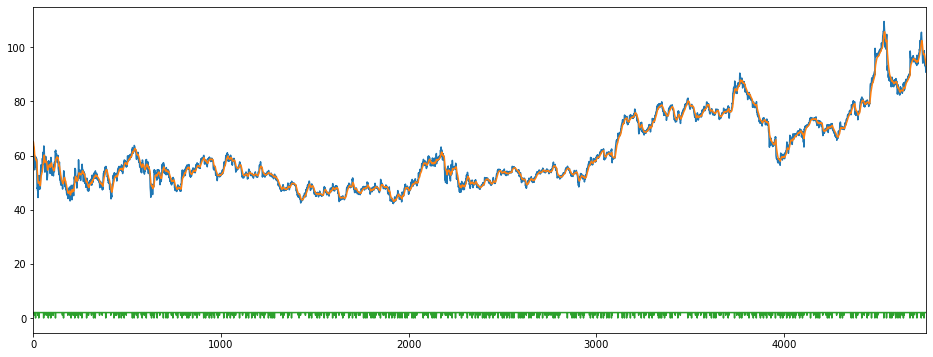

In [135]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [136]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,63.3750,65.176128,-85.271318,-26649200.0,2.0
2000-01-24,62.4375,64.754801,-94.594595,-33601700.0,2.0
2000-01-25,59.3750,63.927139,-83.606557,-41401600.0,2.0
2000-01-26,61.1250,63.496041,-68.306011,-34997800.0,2.0
2000-01-27,61.9375,63.256265,-61.202186,-30459400.0,2.0


In [137]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1

In [138]:
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
X.shape

(4735, 25, 4)

In [139]:
y = labels
y = np.array(y)

In [140]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [141]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [142]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [143]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [144]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 32ms/step - loss: 0.2893 - accuracy: 0.5346 - mse: 0.4472 - weighted_accuracy: 0.3205 - weighted_mse: 0.5280 - val_loss: 0.2989 - val_accuracy: 0.0465 - val_mse: 0.3556 - val_weighted_accuracy: 0.0465 - val_weighted_mse: 0.3556
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2119 - accuracy: 0.4237 - mse: 0.7633 - weighted_accuracy: 0.3993 - weighted_mse: 0.7807 - val_loss: 0.2897 - val_accuracy: 0.0454 - val_mse: 0.3851 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.3851
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1935 - accuracy: 0.3152 - mse: 1.0189 - weighted_accuracy: 0.4424 - weighted_mse: 1.0087 - val_loss: 0.2797 - val_accuracy: 0.0454 - val_mse: 0.4218 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.4218
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1864 - accuracy: 0.3112 - mse: 1.1369 - weighted_accuracy: 0.4804 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1428 - accuracy: 0.3976 - mse: 1.5705 - weighted_accuracy: 0.6828 - weighted_mse: 1.4825 - val_loss: 0.1957 - val_accuracy: 0.3485 - val_mse: 1.6614 - val_weighted_accuracy: 0.3485 - val_weighted_mse: 1.6614
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1416 - accuracy: 0.3960 - mse: 1.5940 - weighted_accuracy: 0.6932 - weighted_mse: 1.5029 - val_loss: 0.2007 - val_accuracy: 0.3200 - val_mse: 1.5875 - val_weighted_accuracy: 0.3200 - val_weighted_mse: 1.5875
Epoch 32/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1399 - accuracy: 0.3746 - mse: 1.6180 - weighted_accuracy: 0.6999 - weighted_mse: 1.5148 - val_loss: 0.1918 - val_accuracy: 0.3516 - val_mse: 1.5750 - val_weighted_accuracy: 0.3516 - val_weighted_mse: 1.5750
Epoch 33/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1399 - accuracy: 0.4145 - mse: 1.6094 - weighted_accuracy: 0.7091 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1191 - accuracy: 0.5275 - mse: 1.9864 - weighted_accuracy: 0.7814 - weighted_mse: 1.9328 - val_loss: 0.1859 - val_accuracy: 0.4688 - val_mse: 2.0928 - val_weighted_accuracy: 0.4688 - val_weighted_mse: 2.0928
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1181 - accuracy: 0.5285 - mse: 2.0181 - weighted_accuracy: 0.7797 - weighted_mse: 1.9650 - val_loss: 0.1836 - val_accuracy: 0.4931 - val_mse: 2.1737 - val_weighted_accuracy: 0.4931 - val_weighted_mse: 2.1737
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1175 - accuracy: 0.5454 - mse: 2.0193 - weighted_accuracy: 0.7954 - weighted_mse: 1.9777 - val_loss: 0.1840 - val_accuracy: 0.4731 - val_mse: 2.1758 - val_weighted_accuracy: 0.4731 - val_weighted_mse: 2.1758
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1167 - accuracy: 0.5388 - mse: 2.0500 - weighted_accuracy: 0.7874 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0972 - accuracy: 0.6386 - mse: 2.6350 - weighted_accuracy: 0.8381 - weighted_mse: 2.6317 - val_loss: 0.1849 - val_accuracy: 0.5026 - val_mse: 2.7088 - val_weighted_accuracy: 0.5026 - val_weighted_mse: 2.7088
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0973 - accuracy: 0.6510 - mse: 2.6830 - weighted_accuracy: 0.8448 - weighted_mse: 2.6844 - val_loss: 0.1852 - val_accuracy: 0.5428 - val_mse: 2.8601 - val_weighted_accuracy: 0.5428 - val_weighted_mse: 2.8601
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0966 - accuracy: 0.6526 - mse: 2.7203 - weighted_accuracy: 0.8471 - weighted_mse: 2.7000 - val_loss: 0.2116 - val_accuracy: 0.4657 - val_mse: 2.8247 - val_weighted_accuracy: 0.4657 - val_weighted_mse: 2.8247
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0961 - accuracy: 0.6463 - mse: 2.7121 - weighted_accuracy: 0.8466 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0783 - accuracy: 0.7328 - mse: 3.7696 - weighted_accuracy: 0.8965 - weighted_mse: 3.7689 - val_loss: 0.1843 - val_accuracy: 0.6188 - val_mse: 4.0554 - val_weighted_accuracy: 0.6188 - val_weighted_mse: 4.0554
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0788 - accuracy: 0.7373 - mse: 3.7729 - weighted_accuracy: 0.8855 - weighted_mse: 3.7581 - val_loss: 0.1850 - val_accuracy: 0.6188 - val_mse: 4.0550 - val_weighted_accuracy: 0.6188 - val_weighted_mse: 4.0550
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0788 - accuracy: 0.7239 - mse: 3.8150 - weighted_accuracy: 0.8914 - weighted_mse: 3.8195 - val_loss: 0.2024 - val_accuracy: 0.5924 - val_mse: 4.4038 - val_weighted_accuracy: 0.5924 - val_weighted_mse: 4.4038
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0770 - accuracy: 0.7513 - mse: 3.8178 - weighted_accuracy: 0.9015 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0625 - accuracy: 0.7951 - mse: 5.1640 - weighted_accuracy: 0.9157 - weighted_mse: 5.1174 - val_loss: 0.2147 - val_accuracy: 0.6030 - val_mse: 5.2832 - val_weighted_accuracy: 0.6030 - val_weighted_mse: 5.2832
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0662 - accuracy: 0.7928 - mse: 5.2231 - weighted_accuracy: 0.9023 - weighted_mse: 5.0926 - val_loss: 0.2174 - val_accuracy: 0.6177 - val_mse: 5.6465 - val_weighted_accuracy: 0.6177 - val_weighted_mse: 5.6465
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0646 - accuracy: 0.7917 - mse: 5.1878 - weighted_accuracy: 0.9090 - weighted_mse: 5.0483 - val_loss: 0.1992 - val_accuracy: 0.6684 - val_mse: 5.9307 - val_weighted_accuracy: 0.6684 - val_weighted_mse: 5.9307
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0644 - accuracy: 0.7970 - mse: 5.2867 - weighted_accuracy: 0.9182 - 

Epoch 175/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0505 - accuracy: 0.8479 - mse: 6.8071 - weighted_accuracy: 0.9423 - weighted_mse: 6.4651 - val_loss: 0.2103 - val_accuracy: 0.6980 - val_mse: 7.3414 - val_weighted_accuracy: 0.6980 - val_weighted_mse: 7.3414
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0524 - accuracy: 0.8466 - mse: 6.7926 - weighted_accuracy: 0.9311 - weighted_mse: 6.4736 - val_loss: 0.2176 - val_accuracy: 0.6800 - val_mse: 7.1859 - val_weighted_accuracy: 0.6800 - val_weighted_mse: 7.1859
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0531 - accuracy: 0.8345 - mse: 6.9171 - weighted_accuracy: 0.9283 - weighted_mse: 6.6794 - val_loss: 0.2278 - val_accuracy: 0.6811 - val_mse: 7.0445 - val_weighted_accuracy: 0.6811 - val_weighted_mse: 7.0445
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0547 - accuracy: 0.8424 - mse: 6.9150 - weighted_accuracy: 0.9314 - 

In [145]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.22790780663490295
Test accuracy: 0.7159450650215149


In [146]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.5090496  -3.4658895  -0.08417722]
 [-5.496895   -7.2903686   5.2093453 ]
 [-2.206294   -1.1613489  -0.0736502 ]
 ...
 [-5.4469132  -1.7948496   1.6317642 ]
 [-2.105603   -2.7196996   1.141139  ]
 [-2.0785892  -2.3465948   0.69443786]]


Counter({2: 757, 1: 103, 0: 87})

In [147]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 860, 0: 44, 1: 43})

In [148]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 947
actual predicted buys: 1
actual buys but predicted sell: 3
actual buys but predicted hold: 39
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 42
actual holds but predicted buy: 101
actual holds but predicted sell: 83
actual predicted holds: 676
Percentage buys correct: 2.3255813953488373%
Percentage sells correct: 2.272727272727273%
Percentage holds correct: 78.6046511627907%
actual buys: 43
actual sells: 44
actual holds: 860


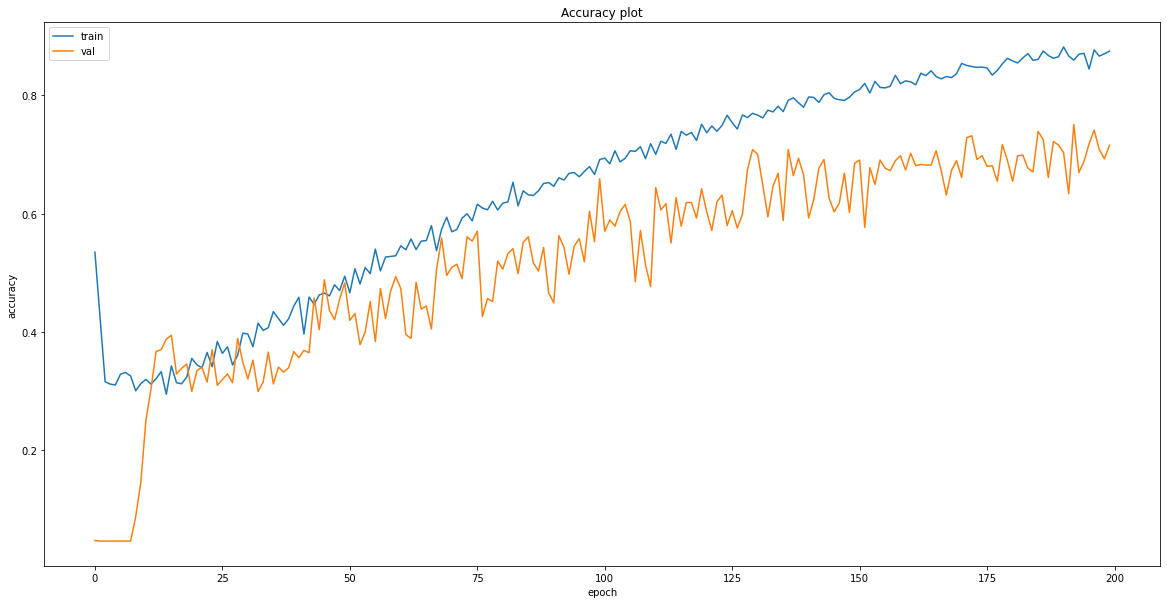

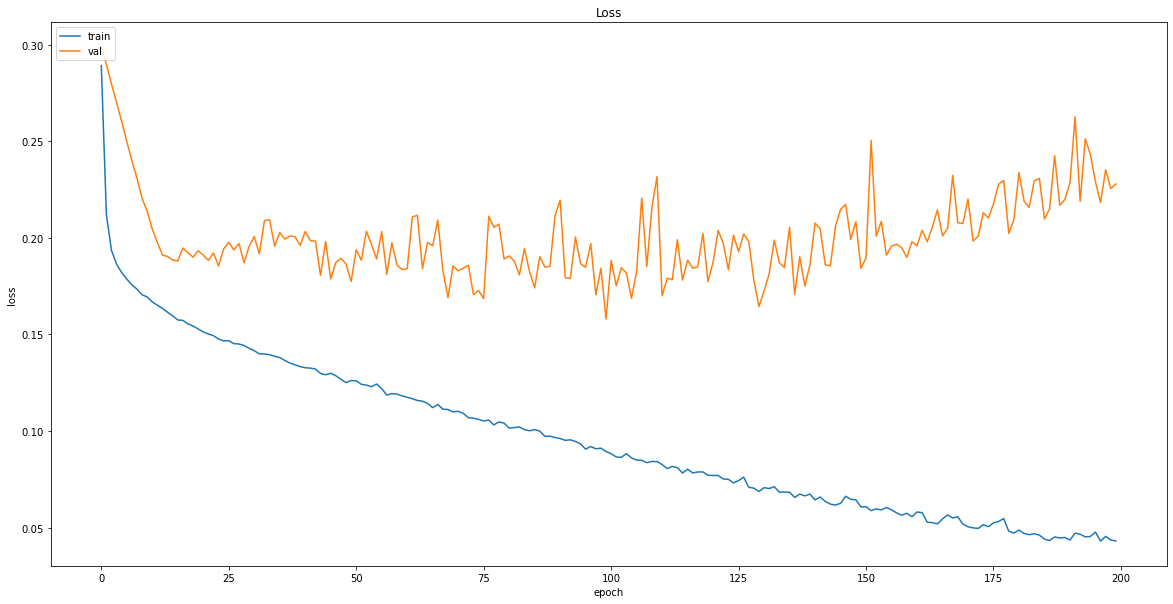

In [149]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [150]:
# Save model
model.save("models/{}".format('wmt_time_series_lstm_buy_hold_sell_25.model'))

INFO:tensorflow:Assets written to: models/wmt_time_series_lstm_buy_hold_sell_25.model\assets


### Test Performance

### non-recession

In [151]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-06,95.809998,97.317381,-74.593506,126209000.0,2.0
2018-12-07,94.769997,96.925476,-82.783532,115841800.0,2.0
2018-12-10,93.190002,96.350788,-89.635777,107345300.0,2.0
2018-12-11,93.940002,95.979897,-77.930950,114622200.0,2.0
2018-12-12,93.849998,95.652221,-79.172384,108169700.0,2.0


In [152]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df2.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(218, 25, 4)

In [153]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [154]:
model = tf.keras.models.load_model("models/wmt_time_series_lstm_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1910 - accuracy: 0.7202 - mean_squared_error: 8.4565 - weighted_accuracy: 0.7202 - weighted_mean_squared_error: 8.4565
Test loss: 0.19099286198616028
Test accuracy: 0.7201834917068481


In [155]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 170, 1: 24, 0: 24})

In [156]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [157]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-157-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-157-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-157-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,96.199997,95.814812,-60.416634,53751900.0,2.0,2,2
2019-02-12,96.970001,95.874072,-50.480811,59294700.0,2.0,2,2
2019-02-13,97.940002,96.042676,-33.448300,65176000.0,2.0,2,2
2019-02-14,98.519997,96.334572,-16.724150,70634500.0,2.0,2,2
2019-02-15,99.989998,96.670792,-11.165857,77835300.0,2.0,2,2


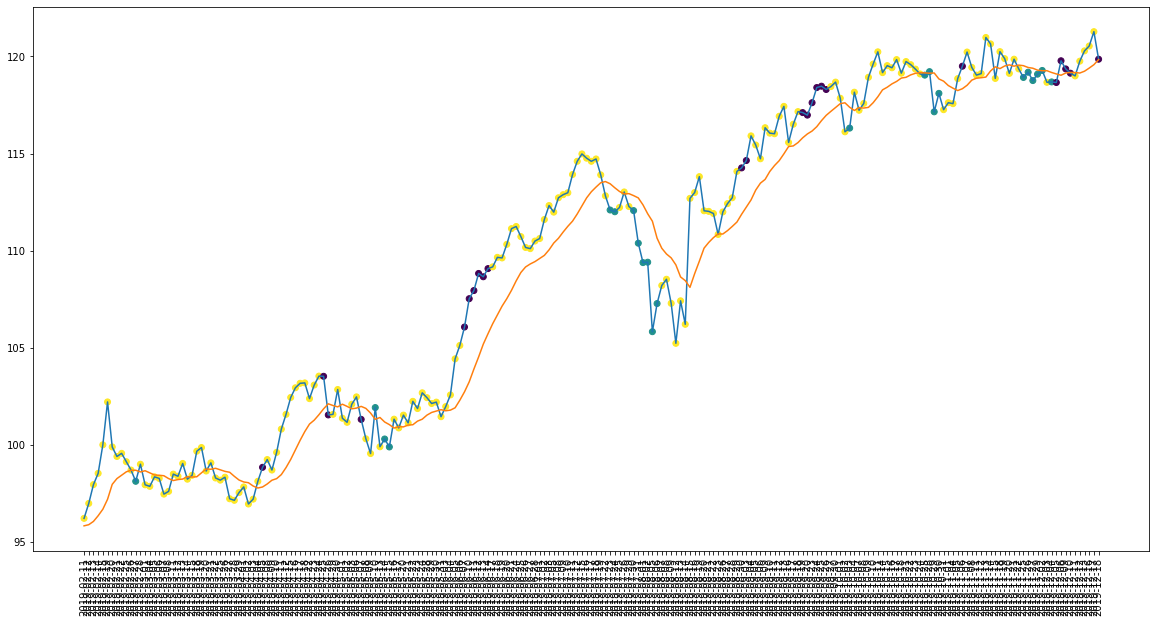

In [158]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

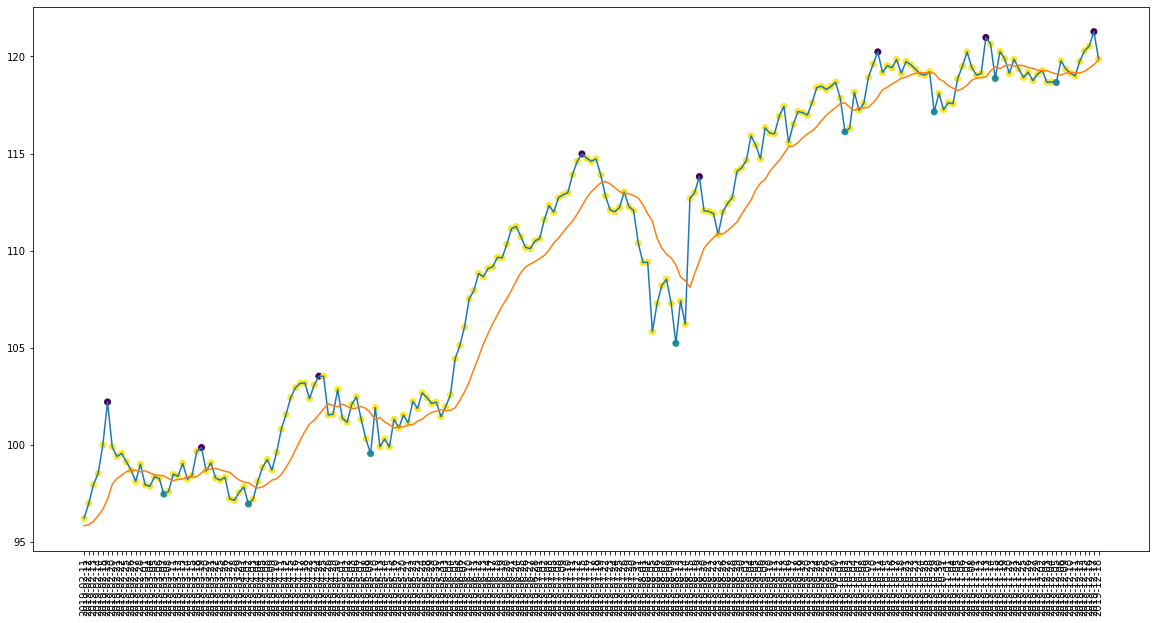

In [159]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [160]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 23
actual holds but predicted sell: 23
actual predicted holds: 156
Percentage buys correct: 12.5%
Percentage sells correct: 0.0%
Percentage holds correct: 77.22772277227723%
actual buys: 8
actual sells: 8
actual holds: 202


In [161]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[96.1999969482422, 96.97000122070312, 97.94000244140624, 98.5199966430664, 99.38999938964844, 99.5500030517578, 99.87999725341795, 99.98999786376952, 102.1999969482422]
[97.8499984741211, 97.93000030517578, 98.11000061035156, 98.69000244140624, 98.98999786376952, 99.12000274658205, 99.38999938964844, 99.5500030517578, 99.87999725341795]
Percentage buys correct: 60.869565217391305%
Percentage sells correct: 37.5%
Percentage holds correct: 84.70588235294117%


In [162]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $98.11000061035156
Shares owned at the moment: 101
Cash capital at the moment: $63.63988568496643


Price increase from previously bought: 5.224846328654453%
Share price: $103.5199966430664
Shares owned at the moment: 0
Cash capital at the moment: $10490.40686756706


Share price: $101.91000366210938
Shares owned at the moment: 102
Cash capital at the moment: $67.00073800468272


Price increase from previously bought: 5.215507496043603%
Share price: $107.5199966430664
Shares owned at the moment: 0
Cash capital at the moment: $11003.881036539076


Share price: $112.08999633789062
Shares owned at the moment: 97
Cash capital at the moment: $101.25138524055365


Stop Loss Activated!

Share price: $105.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10337.563870719909


Share price: $105.81999969482422
Shares owned at the moment: 97
Cash capital at the moment: $44.796415403365245


Price increase from previously bought: 7.679691155263768%
Share price: 

In [163]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12375.78138288879
profit gained: 23.7578138288879%


### Recession

In [164]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-06,118.660004,119.033405,-65.362993,215298600.0,2.0
2019-12-09,119.779999,119.148266,-31.594276,219639400.0,2.0
2019-12-10,119.360001,119.180840,-36.601335,214823400.0,2.0
2019-12-11,119.139999,119.174557,-43.790905,210541100.0,2.0
2019-12-12,119.000000,119.147702,-45.138918,207034700.0,2.0


In [165]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df2.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(219, 25, 4)

In [166]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [167]:
model = tf.keras.models.load_model("models/wmt_time_series_lstm_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1670 - accuracy: 0.7900 - mean_squared_error: 9.6866 - weighted_accuracy: 0.7900 - weighted_mean_squared_error: 9.6866
Test loss: 0.16704703867435455
Test accuracy: 0.7899543642997742


In [168]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 183, 1: 23, 0: 13})

In [169]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [170]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-170-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-170-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-170-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,115.400002,115.836459,-43.516528,-17373100.0,2.0,2,2
2020-02-12,115.849998,115.769312,-40.219793,-11576300.0,2.0,2,2
2020-02-13,117.440002,115.781725,-30.329757,-6840700.0,2.0,2,2
2020-02-14,117.889999,116.036845,-2.057582,-1507500.0,2.0,2,2
2020-02-18,119.629997,116.321946,-14.561040,6623100.0,0.0,2,0


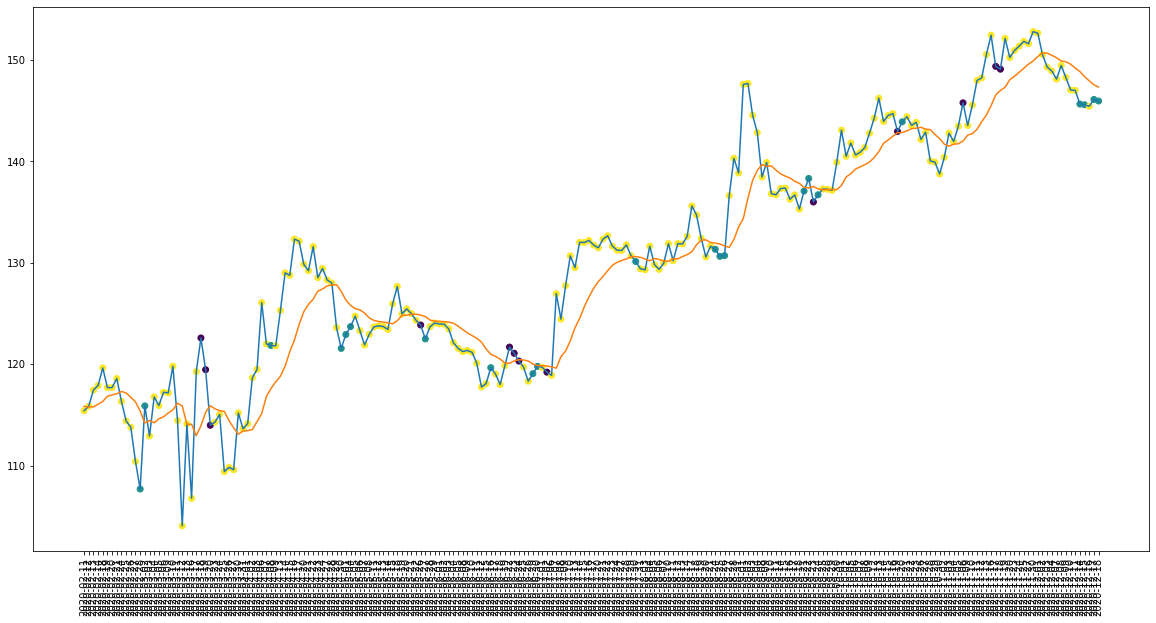

In [171]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

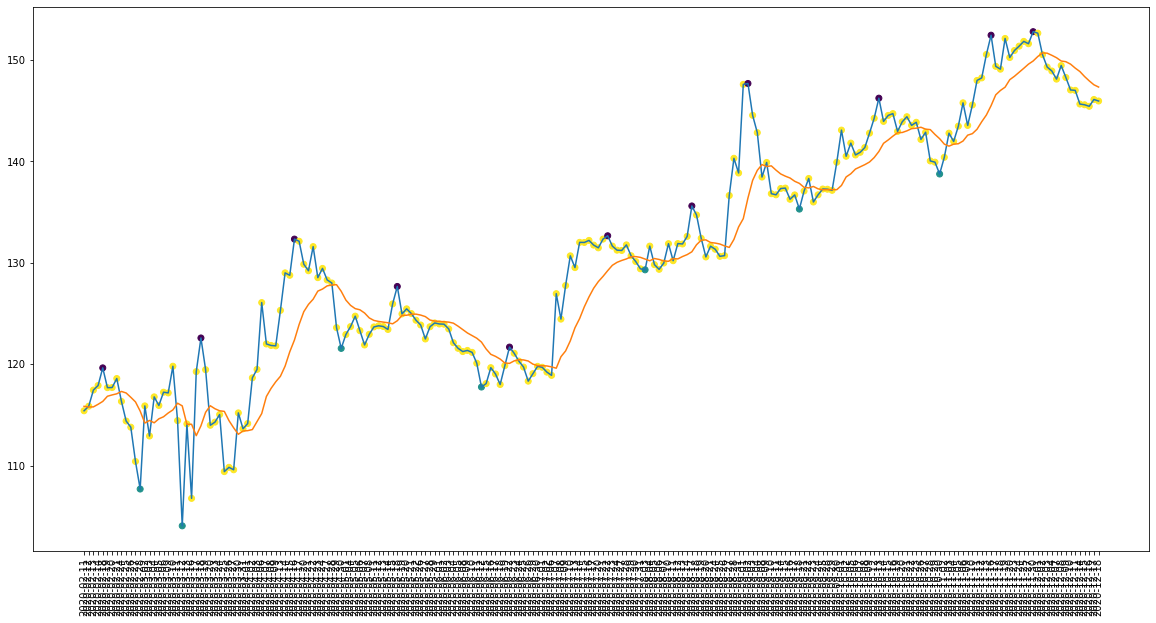

In [172]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [173]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 21
actual holds but predicted sell: 11
actual predicted holds: 169
Percentage buys correct: 28.571428571428573%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 84.07960199004975%
actual buys: 7
actual sells: 11
actual holds: 201


In [174]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[115.4000015258789, 115.8499984741211, 116.31999969482422, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 112.91000366210938, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 63.63636363636363%
Percentage sells correct: 46.15384615384615%
Percentage holds correct: 86.33879781420765%


In [175]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $107.68000030517578
Shares owned at the moment: 92
Cash capital at the moment: $66.1969318466181


Stop Loss Activated!

Share price: $104.0500030517578
Shares owned at the moment: 0
Cash capital at the moment: $9612.47256183624


Share price: $121.83999633789062
Shares owned at the moment: 78
Cash capital at the moment: $82.81816826629438


Stop Loss Activated!

Share price: $117.73999786376952
Shares owned at the moment: 0
Cash capital at the moment: $9241.282772098537


Share price: $119.6500015258789
Shares owned at the moment: 77
Cash capital at the moment: $2.8967667827564583


Price increase from previously bought: 13.344803052702847%
Share price: $135.99000549316406
Shares owned at the moment: 0
Cash capital at the moment: $10445.331306093212


Share price: $136.69999694824222
Shares owned at the moment: 76
Cash capital at the moment: $27.56123866462076


Price increase from previously bought: 6.342530627972787%
Share price: $145.77000427246094
Shares owned at the 

In [176]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%


## Fresh Del Monte Produce Inc

In [177]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14     OBV_7  labels
0  2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
1  2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2  2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
3  2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
4  2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


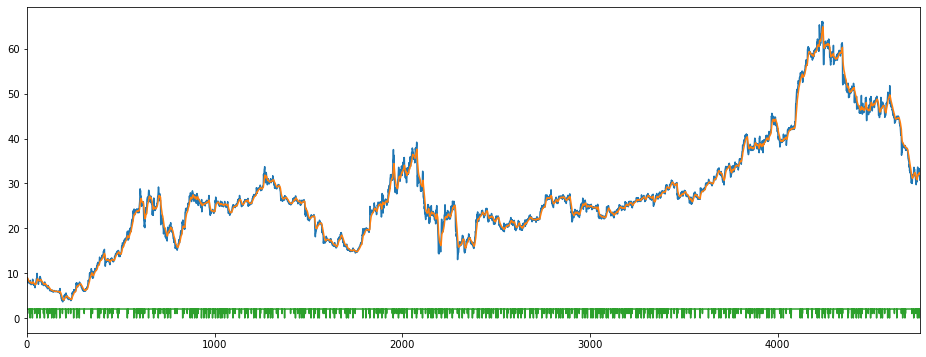

In [178]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [179]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,8.7500,8.946622,-66.666667,78200.0,2.0
2000-01-24,8.8750,8.935603,-58.333333,99900.0,2.0
2000-01-25,9.0000,8.945511,-50.000000,123600.0,2.0
2000-01-26,8.6875,8.905817,-70.833333,87300.0,2.0
2000-01-27,8.5625,8.852999,-76.000000,32400.0,2.0


In [180]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(4735, 25, 4)

In [181]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [182]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [183]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [184]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [185]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 31ms/step - loss: 0.2902 - accuracy: 0.5399 - mse: 0.4509 - weighted_accuracy: 0.3123 - weighted_mse: 0.5382 - val_loss: 0.2988 - val_accuracy: 0.0444 - val_mse: 0.3557 - val_weighted_accuracy: 0.0444 - val_weighted_mse: 0.3557
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2156 - accuracy: 0.3897 - mse: 0.7579 - weighted_accuracy: 0.3824 - weighted_mse: 0.7810 - val_loss: 0.2894 - val_accuracy: 0.0465 - val_mse: 0.3836 - val_weighted_accuracy: 0.0465 - val_weighted_mse: 0.3836
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1958 - accuracy: 0.3506 - mse: 0.9915 - weighted_accuracy: 0.4541 - weighted_mse: 0.9926 - val_loss: 0.2791 - val_accuracy: 0.0465 - val_mse: 0.4214 - val_weighted_accuracy: 0.0465 - val_weighted_mse: 0.4214
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1880 - accuracy: 0.2959 - mse: 1.1380 - weighted_accuracy: 0.4651 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1445 - accuracy: 0.4393 - mse: 1.5034 - weighted_accuracy: 0.6941 - weighted_mse: 1.4383 - val_loss: 0.1822 - val_accuracy: 0.4710 - val_mse: 1.4982 - val_weighted_accuracy: 0.4710 - val_weighted_mse: 1.4982
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1421 - accuracy: 0.4538 - mse: 1.5078 - weighted_accuracy: 0.7031 - weighted_mse: 1.4375 - val_loss: 0.1974 - val_accuracy: 0.3664 - val_mse: 1.5226 - val_weighted_accuracy: 0.3664 - val_weighted_mse: 1.5226
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1415 - accuracy: 0.4374 - mse: 1.5275 - weighted_accuracy: 0.6915 - weighted_mse: 1.4505 - val_loss: 0.1978 - val_accuracy: 0.3685 - val_mse: 1.5758 - val_weighted_accuracy: 0.3685 - val_weighted_mse: 1.5758
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1415 - accuracy: 0.4696 - mse: 1.5233 - weighted_accuracy: 0.7033 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1164 - accuracy: 0.5710 - mse: 1.8562 - weighted_accuracy: 0.7971 - weighted_mse: 1.8102 - val_loss: 0.2329 - val_accuracy: 0.3474 - val_mse: 2.0740 - val_weighted_accuracy: 0.3474 - val_weighted_mse: 2.0740
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1168 - accuracy: 0.5636 - mse: 1.8772 - weighted_accuracy: 0.7871 - weighted_mse: 1.8239 - val_loss: 0.2184 - val_accuracy: 0.4055 - val_mse: 2.0366 - val_weighted_accuracy: 0.4055 - val_weighted_mse: 2.0366
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1166 - accuracy: 0.5826 - mse: 1.8846 - weighted_accuracy: 0.7976 - weighted_mse: 1.8547 - val_loss: 0.1969 - val_accuracy: 0.4625 - val_mse: 1.9991 - val_weighted_accuracy: 0.4625 - val_weighted_mse: 1.9991
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1150 - accuracy: 0.5921 - mse: 1.8740 - weighted_accuracy: 0.7902 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0909 - accuracy: 0.6917 - mse: 2.4807 - weighted_accuracy: 0.8722 - weighted_mse: 2.4843 - val_loss: 0.1868 - val_accuracy: 0.5586 - val_mse: 2.5843 - val_weighted_accuracy: 0.5586 - val_weighted_mse: 2.5843
Epoch 89/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0913 - accuracy: 0.7080 - mse: 2.4446 - weighted_accuracy: 0.8764 - weighted_mse: 2.4402 - val_loss: 0.1835 - val_accuracy: 0.5850 - val_mse: 2.7731 - val_weighted_accuracy: 0.5850 - val_weighted_mse: 2.7731
Epoch 90/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0920 - accuracy: 0.6890 - mse: 2.5184 - weighted_accuracy: 0.8622 - weighted_mse: 2.5088 - val_loss: 0.1881 - val_accuracy: 0.5671 - val_mse: 2.5800 - val_weighted_accuracy: 0.5671 - val_weighted_mse: 2.5800
Epoch 91/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0900 - accuracy: 0.6969 - mse: 2.5247 - weighted_accuracy: 0.8778 - weig

Epoch 117/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0723 - accuracy: 0.7759 - mse: 3.4677 - weighted_accuracy: 0.9050 - weighted_mse: 3.4415 - val_loss: 0.1750 - val_accuracy: 0.6642 - val_mse: 3.5572 - val_weighted_accuracy: 0.6642 - val_weighted_mse: 3.5572
Epoch 118/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0705 - accuracy: 0.7563 - mse: 3.4300 - weighted_accuracy: 0.9033 - weighted_mse: 3.4007 - val_loss: 0.1925 - val_accuracy: 0.6346 - val_mse: 3.6866 - val_weighted_accuracy: 0.6346 - val_weighted_mse: 3.6866
Epoch 119/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0721 - accuracy: 0.7658 - mse: 3.4704 - weighted_accuracy: 0.8977 - weighted_mse: 3.4459 - val_loss: 0.1992 - val_accuracy: 0.6093 - val_mse: 3.8369 - val_weighted_accuracy: 0.6093 - val_weighted_mse: 3.8369
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0722 - accuracy: 0.7735 - mse: 3.5711 - weighted_accuracy: 0.8987 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0555 - accuracy: 0.8310 - mse: 4.7888 - weighted_accuracy: 0.9380 - weighted_mse: 4.6337 - val_loss: 0.1804 - val_accuracy: 0.7265 - val_mse: 5.2521 - val_weighted_accuracy: 0.7265 - val_weighted_mse: 5.2521
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0550 - accuracy: 0.8398 - mse: 4.8313 - weighted_accuracy: 0.9339 - weighted_mse: 4.6641 - val_loss: 0.1890 - val_accuracy: 0.7149 - val_mse: 5.1293 - val_weighted_accuracy: 0.7149 - val_weighted_mse: 5.1293
Epoch 148/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0561 - accuracy: 0.8297 - mse: 4.8804 - weighted_accuracy: 0.9284 - weighted_mse: 4.7179 - val_loss: 0.1766 - val_accuracy: 0.7371 - val_mse: 5.1727 - val_weighted_accuracy: 0.7371 - val_weighted_mse: 5.1727
Epoch 149/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0558 - accuracy: 0.8350 - mse: 4.8834 - weighted_accuracy: 0.9249 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0446 - accuracy: 0.8741 - mse: 6.5447 - weighted_accuracy: 0.9502 - weighted_mse: 6.1855 - val_loss: 0.2162 - val_accuracy: 0.7128 - val_mse: 6.7014 - val_weighted_accuracy: 0.7128 - val_weighted_mse: 6.7014
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0477 - accuracy: 0.8498 - mse: 6.5203 - weighted_accuracy: 0.9394 - weighted_mse: 6.2401 - val_loss: 0.2048 - val_accuracy: 0.7360 - val_mse: 6.7349 - val_weighted_accuracy: 0.7360 - val_weighted_mse: 6.7349
Epoch 177/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0448 - accuracy: 0.8754 - mse: 6.6950 - weighted_accuracy: 0.9506 - weighted_mse: 6.3118 - val_loss: 0.2180 - val_accuracy: 0.7350 - val_mse: 7.0638 - val_weighted_accuracy: 0.7350 - val_weighted_mse: 7.0638
Epoch 178/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0485 - accuracy: 0.8638 - mse: 6.6264 - weighted_accuracy: 0.9445 - 

In [186]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2242850661277771
Test accuracy: 0.7645195126533508


In [187]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[ 0.6858866  -2.0775661  -1.6535653 ]
 [-4.9683013  -5.2501397   4.280134  ]
 [-3.7938466  -3.597794    2.7329876 ]
 ...
 [-1.7677668  -2.4922705   0.6259992 ]
 [-0.6524498  -4.882932    0.17631075]
 [-1.077709   -3.4015343   0.41068655]]


Counter({0: 58, 2: 806, 1: 83})

In [188]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 860, 0: 43, 1: 44})

In [189]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 947
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 43
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 41
actual holds but predicted buy: 81
actual holds but predicted sell: 57
actual predicted holds: 722
Percentage buys correct: 2.272727272727273%
Percentage sells correct: 2.3255813953488373%
Percentage holds correct: 83.95348837209302%
actual buys: 44
actual sells: 43
actual holds: 860


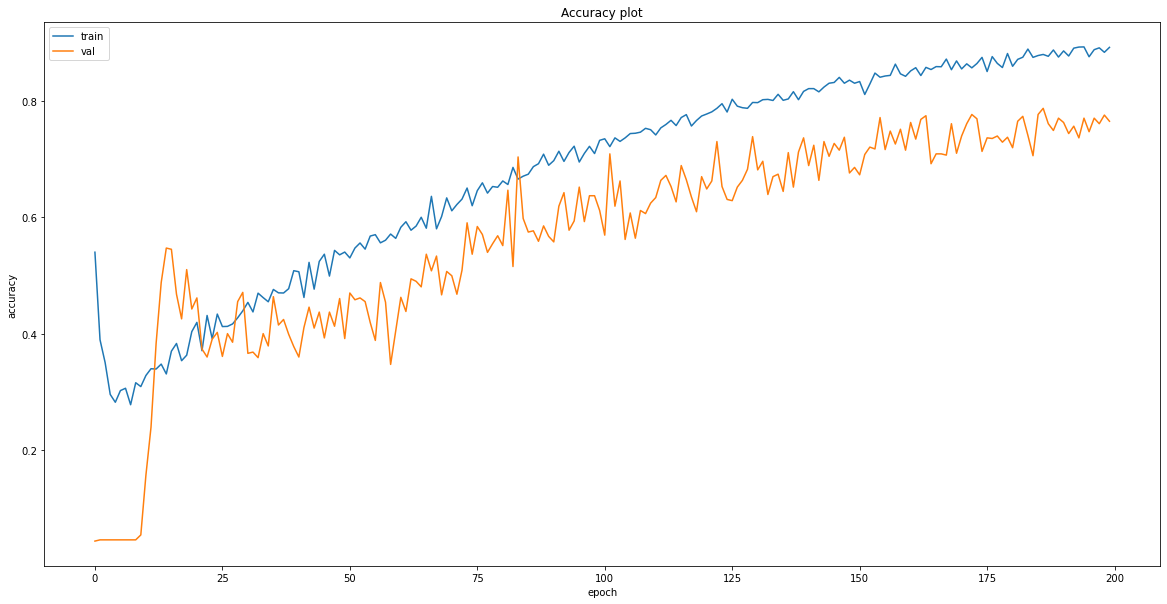

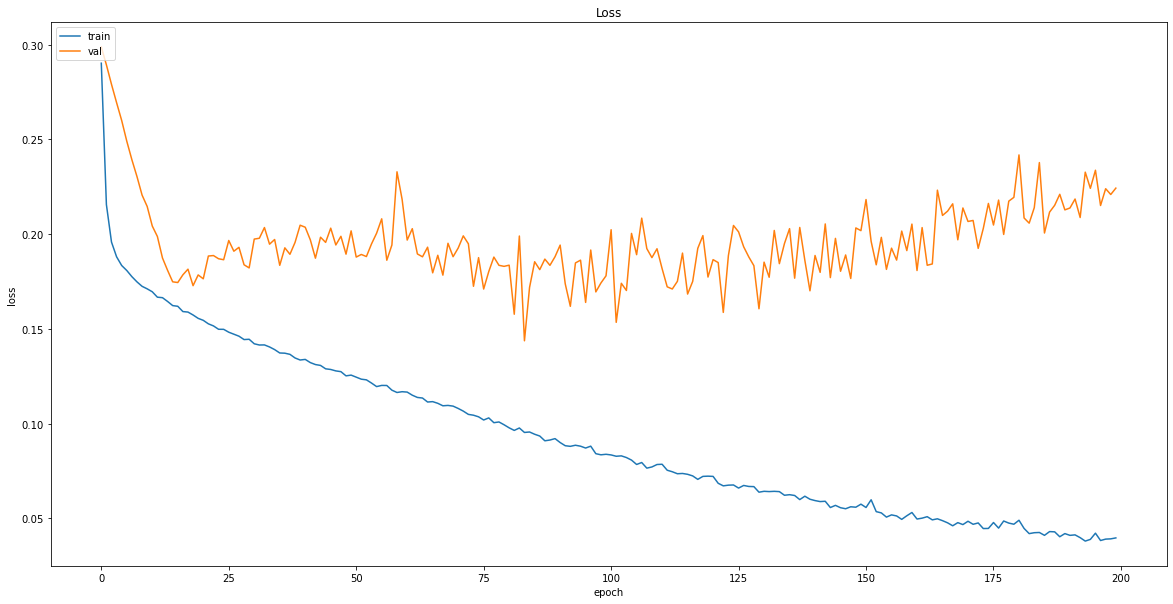

In [190]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [191]:
# Save model
model.save("models/{}".format('FDP_time_series_lstm_buy_hold_sell_25.model'))

INFO:tensorflow:Assets written to: models/FDP_time_series_lstm_buy_hold_sell_25.model\assets


### Test Performance

### non-recession

In [192]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-06,31.690001,31.948964,-55.603431,41248900.0,2.0
2018-12-07,31.969999,31.952200,-49.568976,41460400.0,2.0
2018-12-10,32.189999,31.988784,-44.827613,41674600.0,2.0
2018-12-11,32.000000,31.990510,-48.922410,41408800.0,2.0
2018-12-12,32.380001,32.050432,-40.732734,41626100.0,2.0


In [193]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df2.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(218, 25, 4)

In [194]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [195]:
model = tf.keras.models.load_model("models/FDP_time_series_lstm_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2164 - accuracy: 0.8303 - mean_squared_error: 9.7777 - weighted_accuracy: 0.8303 - weighted_mean_squared_error: 9.7777
Test loss: 0.21640987694263458
Test accuracy: 0.8302752375602722


In [196]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 197, 1: 11, 0: 10})

In [197]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [198]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-198-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-198-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-198-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,33.880001,31.978904,-0.753738,2502700.0,2.0,2,2
2019-02-12,34.610001,32.271381,-0.536205,2611700.0,2.0,2,2
2019-02-13,34.810001,32.631168,-5.603413,2713000.0,2.0,2,2
2019-02-14,34.430000,32.966373,-5.668932,2794100.0,2.0,2,2
2019-02-15,35.220001,33.191547,-14.285733,2675800.0,0.0,2,0


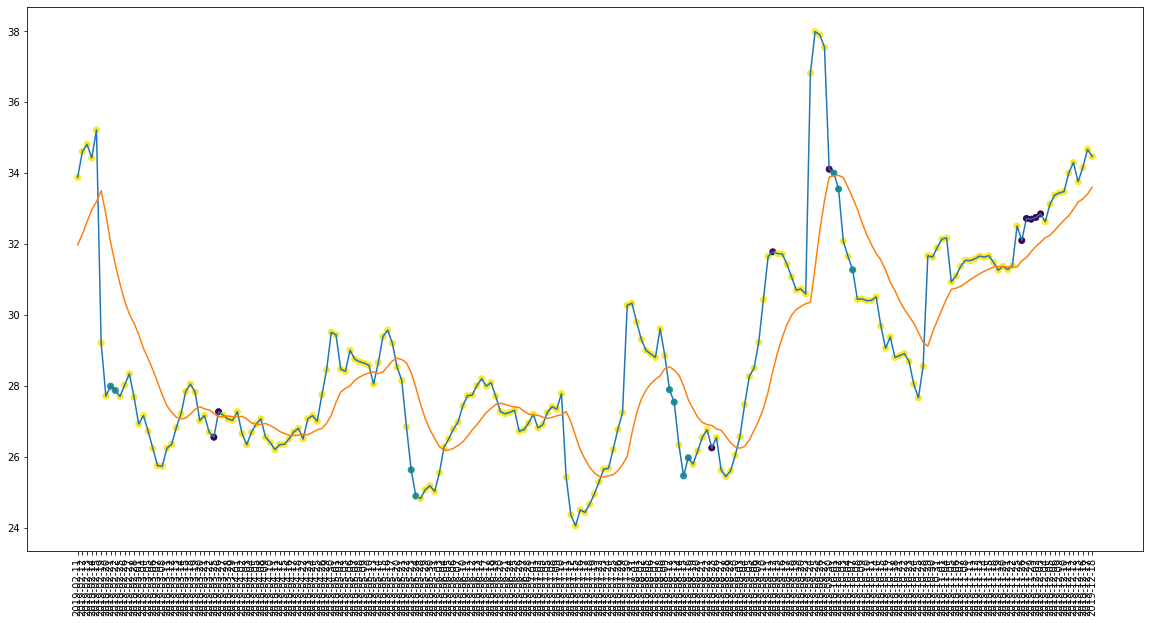

In [199]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

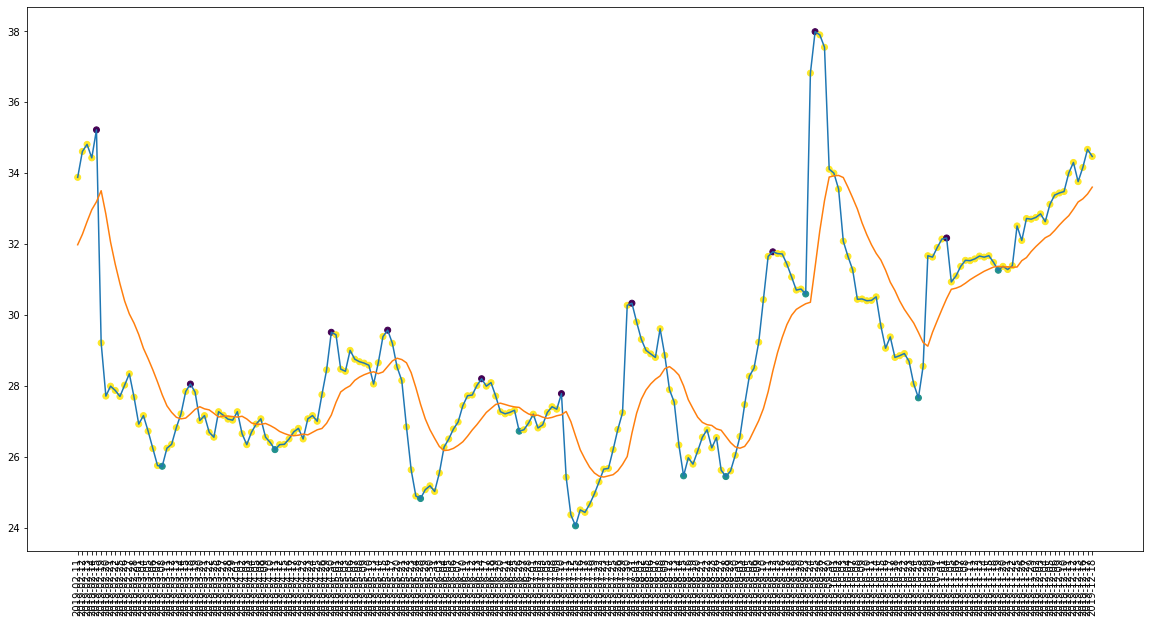

In [200]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [201]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 10
actual holds but predicted sell: 9
actual predicted holds: 179
Percentage buys correct: 10.0%
Percentage sells correct: 10.0%
Percentage holds correct: 90.4040404040404%
actual buys: 10
actual sells: 10
actual holds: 198


In [202]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[27.709999084472656, 27.8700008392334, 27.989999771118164, 29.209999084472656, 33.880001068115234, 34.43000030517578, 34.610000610351555, 34.810001373291016, 35.220001220703125]
[26.920000076293945, 27.15999984741211, 27.68000030517578, 27.70000076293945, 27.709999084472656, 27.8700008392334, 27.989999771118164, 28.020000457763672, 28.34000015258789]
Percentage buys correct: 45.45454545454545%
Percentage sells correct: 60.0%
Percentage holds correct: 84.18367346938776%


In [203]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $27.989999771118164
Shares owned at the moment: 356
Cash capital at the moment: $8.157871706009246


Stop Loss Activated!

Share price: $26.920000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9565.323218791962


Share price: $25.6299991607666
Shares owned at the moment: 372
Cash capital at the moment: $4.744041845322499


Stop Loss Activated!

Share price: $24.88999938964844
Shares owned at the moment: 0
Cash capital at the moment: $9238.361345418933


Share price: $24.88999938964844
Shares owned at the moment: 370
Cash capital at the moment: $3.7359968700420723


Stop Loss Activated!

Share price: $24.04999923706055
Shares owned at the moment: 0
Cash capital at the moment: $8877.764840358737


Share price: $27.88999938964844
Shares owned at the moment: 317
Cash capital at the moment: $12.321926872255062


Stop Loss Activated!

Share price: $26.32999992370605
Shares owned at the moment: 0
Cash capital at the moment: $8335.97872525358


Share price: $

In [204]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10118.19906801033
profit gained: 1.1819906801032993%


### recession

In [205]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-06,33.119999,32.380699,-4.000007,-5771300.0,2.0
2019-12-09,33.380001,32.534438,-13.261606,-5572400.0,2.0
2019-12-10,33.439999,32.673755,-11.111157,-5391600.0,2.0
2019-12-11,33.480000,32.797793,-10.954105,-5223300.0,2.0
2019-12-12,34.000000,32.982748,-1.298730,-5082700.0,2.0


In [206]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df2.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(219, 25, 4)

In [207]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [208]:
model = tf.keras.models.load_model("models/FDP_time_series_lstm_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1733 - accuracy: 0.8311 - mean_squared_error: 9.4720 - weighted_accuracy: 0.8311 - weighted_mean_squared_error: 9.4720
Test loss: 0.17328673601150513
Test accuracy: 0.8310502171516418


In [209]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 197, 1: 15, 0: 7})

In [210]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [211]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-211-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-211-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-211-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,33.930000,32.680842,-26.373606,310600.0,2.0,2,2
2020-02-12,34.410000,32.873020,-19.505473,431300.0,2.0,2,2
2020-02-13,34.240002,33.109478,-14.750004,582800.0,2.0,2,2
2020-02-14,34.480000,33.283405,-18.999958,490800.0,0.0,2,0
2020-02-18,34.009998,33.467496,-13.000011,587800.0,2.0,2,2


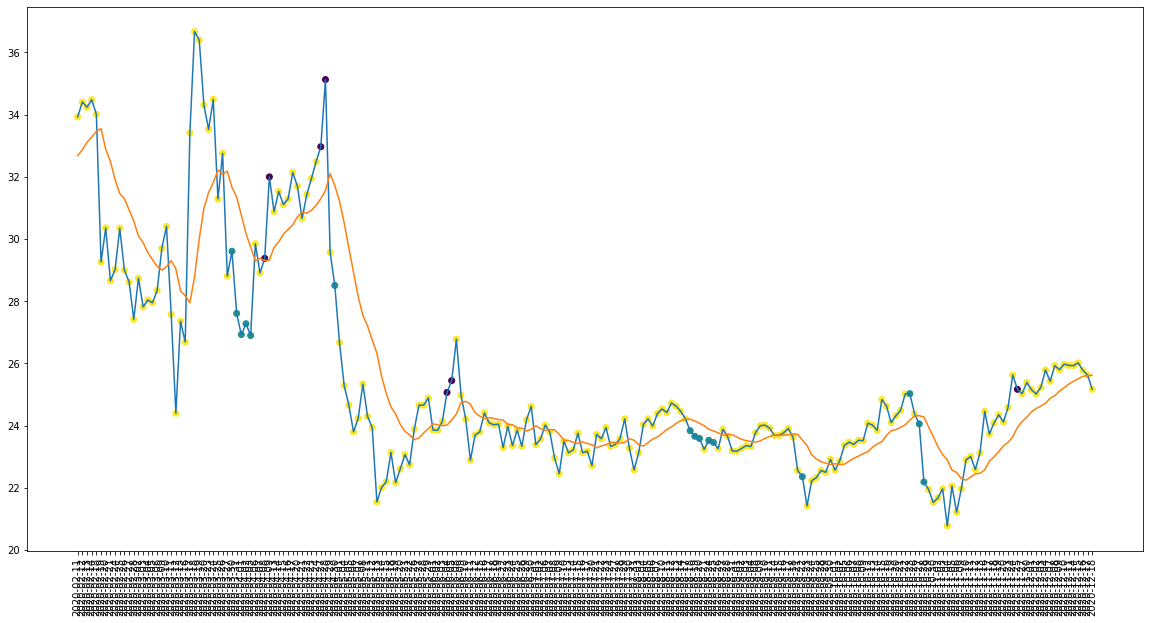

In [212]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

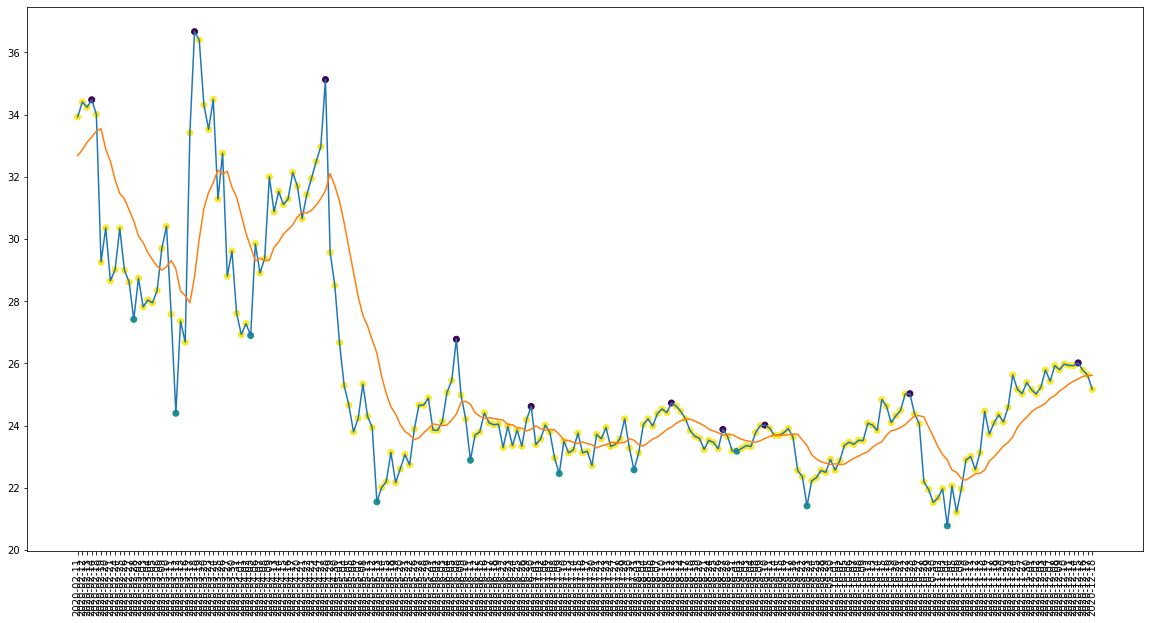

In [213]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [214]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 13
actual holds but predicted sell: 6
actual predicted holds: 180
Percentage buys correct: 10.0%
Percentage sells correct: 10.0%
Percentage holds correct: 90.45226130653266%
actual buys: 10
actual sells: 10
actual holds: 199


In [215]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[28.65999984741211, 29.020000457763672, 29.26000022888184, 30.36000061035156, 33.93000030517578, 34.009998321533196, 34.240001678466804, 34.40999984741211, 34.47999954223633]
[27.420000076293945, 27.81999969482422, 28.6200008392334, 28.65999984741211, 28.739999771118164, 29.0, 29.020000457763672, 30.35000038146973, 30.36000061035156]
Percentage buys correct: 46.666666666666664%
Percentage sells correct: 85.71428571428571%
Percentage holds correct: 82.65306122448979%


In [216]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $29.61000061035156
Shares owned at the moment: 336
Cash capital at the moment: $23.680154357911306


Stop Loss Activated!

Share price: $27.61000061035156
Shares owned at the moment: 0
Cash capital at the moment: $9275.128718872069


Share price: $27.61000061035156
Shares owned at the moment: 335
Cash capital at the moment: $0.3428013420107163


Price increase from previously bought: 6.118888418266422%
Share price: $29.3799991607666
Shares owned at the moment: 0
Cash capital at the moment: $9815.576195971966


Share price: $28.51000022888184
Shares owned at the moment: 343
Cash capital at the moment: $9.754059749600856


Stop Loss Activated!

Share price: $26.670000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9132.407608346459


Share price: $23.84000015258789
Shares owned at the moment: 382
Cash capital at the moment: $0.48362989759152697


Stop Loss Activated!

Share price: $23.18000030517578
Shares owned at the moment: 0
Cash capital at the momen

In [217]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7385.700107630253
profit gained: -26.14299892369747%
